# Pytorch Rals-C-SAGAN
* Ra - Relativistic Average;
* Ls - Least Squares;
* C - Conditional;
* SA - Self-Attention;
* DCGAN - Deep Convolutional Generative Adversarial Network

<br>
References:
* https://www.kaggle.com/speedwagon/ralsgan-dogs
* https://www.kaggle.com/cdeotte/dog-breed-cgan
* https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cgan/cgan.py
* https://github.com/voletiv/self-attention-GAN-pytorch/blob/master/sagan_models.py

In [1]:
# loss_calculation = 'hinge'
loss_calculation = 'rals'
batch_size = 32
crop_dog = True #犬のアノテーションを使用するかどうか
noisy_label = True #ラベルスムージング的な
R_uni = (0.85, 0.95) #ラベルスムージングするときのrealの範囲
F_uni = (0.05, 0.15) #ラベルスムージングするときのfakeの範囲
Gcbn = False # generatorにConditionalBatchNorm2dを使うかどうか
Glrelu = False # generatorにLeakyLeLUを使うかどうか
flip_p = 0.0 # RandomHorizontalFlipの割合
n_epochs = 301

use_pixelnorm = False
test_mode = True # commit時はFalseにしてinternetをoffにする
colapse_thre = 0.5 # modecolapseのしきい値
use_Gattn = True
use_Dattn = False

# optimizerゾーン
# G_opt = 'adaboundw'
G_opt = 'adam'
G_lr = 0.0002
G_betas = (0.5, 0.999) #ada系のみ
G_final_lr=0.5 # adaboundのみ
G_weight_decay=5e-4 # adaboundのみ
G_eta_min = 0.0003 # コサインアニーリングのパラメタ

# D_opt = 'adaboundw'
D_opt = 'adam'
# D_opt = 'SGD'
D_lr = 0.0002
D_betas = (0.5, 0.999) #ada系のみ
D_final_lr=0.1 # adaboundのみ
D_weight_decay=0 #adaboundのみ
D_eta_min = 0.0003

In [2]:
import requests
import datetime
import io
import os

import matplotlib.pyplot as plt

def notify(messages, files=None):
    url = "https://notify-api.line.me/api/notify"
    token = 'bVQ1eoiM1a8NuLwpw6iRRwnvPruRjRpjWMilh0D8E36'
    headers = {"Authorization" : "Bearer "+ token}
    payload = {"message" :  messages}

    r = requests.post(url ,headers = headers ,params=payload,files=files)

In [3]:
import os
import PIL
import torchvision
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import xml.etree.ElementTree as ET
import numpy as np

import imgaug as ia
import imgaug.augmenters as iaa

import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.nn.init import xavier_uniform_


import time
import torch
import torch.nn as nn

import torch.nn.parallel
import torch.optim as optim
from torch.nn.utils import spectral_norm
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.image as mpimg

import torch.nn.functional as F
from torch.nn import Parameter


import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image
import zipfile

from tqdm import tqdm_notebook as tqdm
torch.backends.cudnn.deterministic = True

kernel_start_time = time.perf_counter()

# Helper Blocks

In [4]:
import math
import torch
from torch.optim import Optimizer


class AdaBound(Optimizer):
    """Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss

class AdaBoundW(Optimizer):
    """Implements AdaBound algorithm with Decoupled Weight Decay (arxiv.org/abs/1711.05101)
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBoundW, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBoundW, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                if group['weight_decay'] != 0:
                    decayed_weights = torch.mul(p.data, group['weight_decay'])
                    p.data.add_(-step_size)
                    p.data.sub_(decayed_weights)
                else:
                    p.data.add_(-step_size)

        return loss

In [5]:
# スペクトラルノルム使ったコンボそう
def snconv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
    return spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias))
# スペクトラルノルム使った全結合層
def snlinear(in_features, out_features):
    return spectral_norm(nn.Linear(in_features=in_features, out_features=out_features))

#スペクトラルノルム使ったエンべ層
def sn_embedding(num_embeddings, embedding_dim):
    return spectral_norm(nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim))

#カーネルのアテンションクラス
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_channels):
        super(Self_Attn, self).__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_phi = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_g = snconv2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_attn = snconv2d(in_channels=in_channels//2, out_channels=in_channels, kernel_size=1, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=0)
        self.softmax  = nn.Softmax(dim=-1)
        self.sigma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        _, ch, h, w = x.size()
        # Theta path
        theta = self.snconv1x1_theta(x)
        theta = theta.view(-1, ch//8, h*w)
        # Phi path
        phi = self.snconv1x1_phi(x)
        phi = self.maxpool(phi)
        phi = phi.view(-1, ch//8, h*w//4)
        # Attn map
        attn = torch.bmm(theta.permute(0, 2, 1), phi)
        attn = self.softmax(attn)
        # g path
        g = self.snconv1x1_g(x)
        g = self.maxpool(g)
        g = g.view(-1, ch//2, h*w//4)
        # Attn_g
        attn_g = torch.bmm(g, attn.permute(0, 2, 1))
        attn_g = attn_g.view(-1, ch//2, h, w)
        attn_g = self.snconv1x1_attn(attn_g)
        # Out
        out = x + self.sigma * attn_g
        return out

    
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        self.embed.weight.data[:, :num_features].fill_(1.)  # Initialize scale to 1
        self.embed.weight.data[:, num_features:].zero_()    # Initialize bias at 0

    def forward(self, inputs):
        x, y = inputs
        
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, 1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        return out

# Generator and Discriminator

In [11]:
class UpConvBlock(nn.Module):
    """
    n_cl クラス数(120),
    k_s=カーネルサイズ(4), 
    stride=stride(2), 
    padding=padding(0), 
    bias=バイアス入れるかどうか（False),
    dropout_p=dropout_p(0.0), 
    use_cbn=Conditional Batch Normalization使うかどうか(True)
    Lrelu=LeakyReLU使うかどうか(True)(FalseはReLU)
    slope=Lreluのslope(0.05)
    """
    def __init__(self, n_input, n_output, n_cl, k_s=4, stride=2, padding=0, 
                 bias=False, dropout_p=0.0, use_cbn=True, Lrelu=True, slope=0.05):
        super(UpConvBlock, self).__init__()
        self.use_cbn = use_cbn
        self.dropout_p=dropout_p
        self.upconv = spectral_norm(nn.ConvTranspose2d(n_input, n_output, kernel_size=k_s, stride=stride, padding=padding, bias=bias))
        if use_cbn:
            self.cond_bn = ConditionalBatchNorm2d(n_output, n_cl)
        else: 
            self.bn = nn.BatchNorm2d(n_output)
        if Lrelu:
            self.activ = nn.LeakyReLU(slope, inplace=True)
        else:
            self.activ = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=dropout_p)
        
    def forward(self, inputs):
        x0, labels = inputs
        
        x = self.upconv(x0)
        if self.use_cbn: 
            x = self.activ(self.cond_bn((x, labels)))
        else:            
            x = self.activ(self.bn(x))
        if self.dropout_p > 0.0: 
            x = self.dropout(x)
        return x


class Generator(nn.Module):
    def __init__(self, nz=128, num_classes=120, channels=3, nfilt=64,use_cbn=True, Lrelu=True):
        super(Generator, self).__init__()
        self.nz = nz
        self.num_classes = num_classes
        self.channels = channels
        
        self.label_emb = nn.Embedding(num_classes, nz)
        self.upconv1 = UpConvBlock(2*nz, nfilt*8, num_classes, k_s=4, stride=1, padding=0, use_cbn=use_cbn,Lrelu=Lrelu) #4*4
        self.upconv2 = UpConvBlock(nfilt*8, nfilt*4, num_classes, k_s=4, stride=2, padding=1,use_cbn=use_cbn,Lrelu=Lrelu) #8*8 
        self.upconv3 = UpConvBlock(nfilt*4, nfilt*2, num_classes, k_s=4, stride=2, padding=1,use_cbn=use_cbn,Lrelu=Lrelu) # 16*16
        self.upconv4 = UpConvBlock(nfilt*2, nfilt, num_classes, k_s=4, stride=2, padding=1, use_cbn=use_cbn,Lrelu=Lrelu) #32*32
        self.upconv5 = UpConvBlock(nfilt, 3, num_classes, k_s=4, stride=2, padding=1, use_cbn=use_cbn,Lrelu=Lrelu) 
        if use_Gattn:
            self.self_attn = Self_Attn(nfilt)
        self.out_conv = spectral_norm(nn.Conv2d(3, 3, 3, 1, 1, bias=False))
        self.out_activ = nn.Tanh()
        
    def forward(self, inputs):
        z, labels = inputs
        
        enc = self.label_emb(labels).view((-1, self.nz, 1, 1))
        enc = F.normalize(enc, p=2, dim=1)
        x = torch.cat((z, enc), 1)
        x = self.upconv1((x, labels))
        x = self.upconv2((x, labels))
        x = self.upconv3((x, labels))
        x = self.upconv4((x, labels))
        if use_Gattn:
            x = self.self_attn(x)
        x = self.upconv5((x, labels))
        x = self.out_conv(x)
        img = self.out_activ(x)              
        return img
    
    
class Discriminator(nn.Module):
    def __init__(self, num_classes=120, channels=3, nfilt=64):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.num_classes = num_classes

        def down_convlayer(n_input, n_output, k_s=4, stride=2, padding=0, dropout_p=0.0):
            block = [spectral_norm(nn.Conv2d(n_input, n_output, kernel_size=k_s, stride=stride, padding=padding, bias=False)),
                     nn.BatchNorm2d(n_output),
                     nn.LeakyReLU(0.2, inplace=True),
                    ]
            if dropout_p > 0.0: block.append(nn.Dropout(p=dropout_p))
            return block
        
        self.label_emb = nn.Embedding(num_classes, 64*64)
        if use_Dattn:
            self.model = nn.Sequential(
                *down_convlayer(self.channels + 1, nfilt, 4, 2, 1), 
                Self_Attn(nfilt),                            
                *down_convlayer(nfilt, nfilt*2, 4, 2, 1),
                *down_convlayer(nfilt*2, nfilt*4, 4, 2, 1),
                *down_convlayer(nfilt*4, nfilt*8, 4, 2, 1),
                spectral_norm(nn.Conv2d(nfilt*8, 1, 4, 1, 0, bias=False)),
            )

        else:
            self.model = nn.Sequential(
                *down_convlayer(self.channels + 1, nfilt, 4, 2, 1),            
                *down_convlayer(nfilt, nfilt*2, 4, 2, 1),
                *down_convlayer(nfilt*2, nfilt*4, 4, 2, 1),
                *down_convlayer(nfilt*4, nfilt*8, 4, 2, 1),
                spectral_norm(nn.Conv2d(nfilt*8, 1, 4, 1, 0, bias=False)),
            )

    def forward(self, inputs):
        imgs, labels = inputs

        enc = self.label_emb(labels).view((-1, 1, 64, 64))
        enc = F.normalize(enc, p=2, dim=1)
        x = torch.cat((imgs, enc), 1)   # 4 input feature maps(3rgb + 1label)
        
        out = self.model(x)
        return out.view(-1)

    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constrideant_(m.bias.data, 0)

# Data loader

In [8]:
class DataGenerator(Dataset):
    def __init__(self, directory, transform=None, n_samples=np.inf, crop_dogs=True):
        self.directory = directory
        self.transform = transform
        self.n_samples = n_samples        
        self.samples, self.labels = self.load_dogs_data(directory, crop_dogs)

    def load_dogs_data(self, directory, crop_dogs):
        required_transforms = torchvision.transforms.Compose([
                torchvision.transforms.Resize(64),
                torchvision.transforms.CenterCrop(64),
        ])

        imgs = []
        labels = []
        paths = []
        for root, _, fnames in sorted(os.walk(directory)):
            for fname in sorted(fnames)[:min(self.n_samples, 999999999999999)]:
                path = os.path.join(root, fname)
                paths.append(path)

        for path in paths:
            # Load image
            try: img = dset.folder.default_loader(path)
            except: continue
            
            # Get bounding boxes
            annotation_basename = os.path.splitext(os.path.basename(path))[0]
            annotation_dirname = next(
                    dirname for dirname in os.listdir('../input/annotation/Annotation/') if
                    dirname.startswith(annotation_basename.split('_')[0]))
                
            if crop_dogs:
                tree = ET.parse(os.path.join('../input/annotation/Annotation/',
                                             annotation_dirname, annotation_basename))
                root = tree.getroot()
                objects = root.findall('object')
                for o in objects:
                    bndbox = o.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    object_img = required_transforms(img.crop((xmin, ymin, xmax, ymax)))
                    imgs.append(object_img)
                    labels.append(annotation_dirname.split('-')[1].lower())

            else:
                object_img = required_transforms(img)
                imgs.append(object_img)
                labels.append(annotation_dirname.split('-')[1].lower())
            
        return imgs, labels
    
    
    def __getitem__(self, index):
        sample = self.samples[index]
        label = self.labels[index]
        
        if self.transform is not None: 
            sample = self.transform(sample)
        return np.asarray(sample), label

    
    def __len__(self):
        return len(self.samples)

## Training Parameters

In [9]:
database = '../input/all-dogs/all-dogs/'
crop_dogs = crop_dog
n_samples = np.inf
BATCH_SIZE = batch_size

epochs = n_epochs

use_soft_noisy_labels=noisy_label #ラベルスムージングするかどうか
loss_calc = loss_calculation

nz = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([transforms.RandomHorizontalFlip(p=flip_p),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DataGenerator(database, transform=transform, n_samples=n_samples, crop_dogs=crop_dogs)

decoded_dog_labels = {i:breed for i, breed in enumerate(sorted(set(train_data.labels)))}
encoded_dog_labels = {breed:i for i, breed in enumerate(sorted(set(train_data.labels)))}
train_data.labels = [encoded_dog_labels[l] for l in train_data.labels] # encode dog labels in the data generator


train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=BATCH_SIZE, num_workers=4)

    
print("Dog breeds loaded:  ", len(encoded_dog_labels))
print("Data samples loaded:", len(train_data))

Dog breeds loaded:   120
Data samples loaded: 22125


In [12]:
netG = Generator(nz, num_classes=len(encoded_dog_labels), nfilt=64,use_cbn=Gcbn, Lrelu=Glrelu).to(device)
netD = Discriminator(num_classes=len(encoded_dog_labels), nfilt=64).to(device)
weights_init(netG)
weights_init(netD)
print("Generator parameters:    ", sum(p.numel() for p in netG.parameters() if p.requires_grad))
print("Discriminator parameters:", sum(p.numel() for p in netD.parameters() if p.requires_grad))

if G_opt == 'adaboundw':
    optimizerG = AdaBoundW(netG.parameters(), lr=G_lr, betas=G_betas,final_lr=G_final_lr,weight_decay=G_weight_decay)
elif G_opt == 'adam':
    optimizerG = optim.Adam(netG.parameters(), lr=G_lr, betas=G_betas)
    
if D_opt == 'adaboundw':
    optimizerD = AdaBoundW(netD.parameters(), lr=D_lr, betas=D_betas,final_lr=D_final_lr,weight_decay=D_weight_decay)
elif D_opt == 'adam':
    optimizerD = optim.Adam(netD.parameters(), lr=D_lr, betas=D_betas)
elif D_opt == 'SGD':
    optimizerD = optim.SGD(netD.parameters(), lr=D_lr)

# lr_schedulerG = torch.optim.lr_scheduler.ExponentialLR(optimizerG, gamma=.99)
# lr_schedulerD = torch.optim.lr_scheduler.ExponentialLR(optimizerD, gamma=.99)

lr_schedulerG = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerG, T_0=epochs//20, eta_min=G_eta_min)
lr_schedulerD = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerD, T_0=epochs//20, eta_min=D_eta_min)

Generator parameters:     4875336
Discriminator parameters: 3258240


In [13]:
def mse(imageA, imageB):
        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])
        return err

def show_generated_img(n_images=5, nz=128):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        dog_label = torch.randint(0, len(encoded_dog_labels), (1, ), device=device)
        gen_image = netG((noise, dog_label)).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
        
    figure, axes = plt.subplots(1, len(sample), figsize=(64, 64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = (sample[index] + 1.) / 2.
        axis.imshow(image_array)
    plt.show()
    
    return image_array

    
def analyse_generated_by_class(n_images=5):
    good_breeds = []
    for l in range(len(decoded_dog_labels)):
        sample = []
        for _ in range(n_images):
            noise = torch.randn(1, nz, 1, 1, device=device)
            dog_label = torch.full((1,) , l, device=device, dtype=torch.long)
            gen_image = netG((noise, dog_label)).to("cpu").clone().detach().squeeze(0)
            gen_image = gen_image.numpy().transpose(1, 2, 0)
            sample.append(gen_image)
        
        d = np.round(np.sum([mse(sample[k], sample[k+1]) for k in range(len(sample)-1)])/n_images, 1)
        
        if l % 10 == 0:            
            print(f"Generated breed({d}): ", decoded_dog_labels[l])
            figure, axes = plt.subplots(1, len(sample), figsize=(64, 64))
            for index, axis in enumerate(axes):
                axis.axis('off')
                image_array = (sample[index] + 1.) / 2.
                axis.imshow(image_array)
            plt.show()
        if d < colapse_thre:
            print(f"colapse_breed({d}): ", decoded_dog_labels[l])
            continue  # had mode colapse(discard)
        good_breeds.append(l)           
        
    return good_breeds


def create_submit(good_breeds):
    print("Creating submit")
    os.makedirs('../output_images', exist_ok=True)
    im_batch_size = 100
    n_images = 10000
    
    all_dog_labels = np.random.choice(good_breeds, size=n_images, replace=True)
    for i_batch in range(0, n_images, im_batch_size):
        dog_labels = torch.from_numpy(all_dog_labels[i_batch: (i_batch+im_batch_size)]).to(device)
        noise = torch.randn(im_batch_size, nz, 1, 1, device=device)
        gen_images = netG((noise, dog_labels))
        gen_images = (gen_images.to("cpu").clone().detach() + 1) / 2
        for ii, img in enumerate(gen_images):
            save_image(gen_images[ii, :, :, :], os.path.join('../output_images', f'image_{i_batch + ii:05d}.png'))
            
    import shutil
    shutil.make_archive('images', 'zip', '../output_images')

## Training loop

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


loss=rals 1epochの中での平均値 
 43.78s [1/301] Loss_D: 0.1354 Loss_G: 3.3984 outputR: -1.5715 outputF: -2.3608 / -2.5146
  最後のバッチのloss等 
    43.78s [1/301] Loss_D: 0.0816 Loss_G: 4.2803 outputR: -2.3005 outputF: -3.2011 / -3.4567


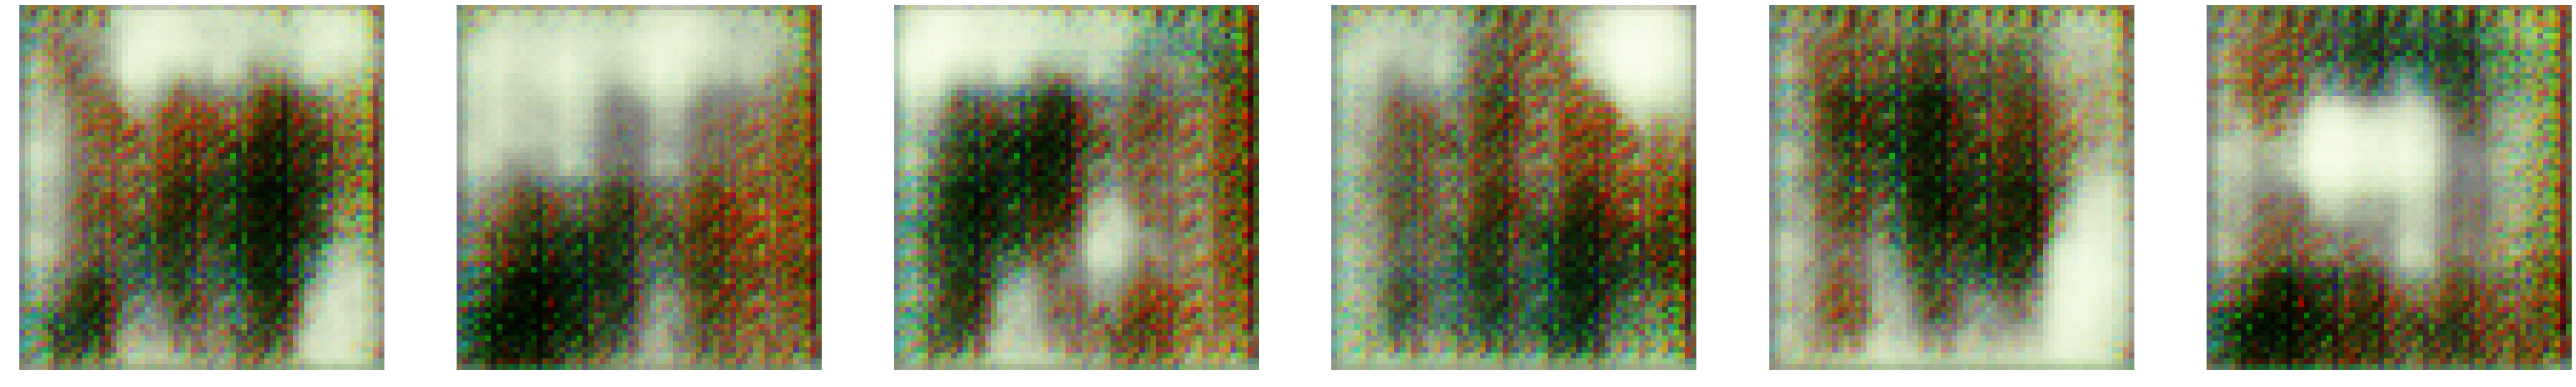

loss=rals 1epochの中での平均値 
 42.98s [2/301] Loss_D: 0.1750 Loss_G: 3.6652 outputR: -2.2244 outputF: -2.9285 / -3.2404
  最後のバッチのloss等 
    42.98s [2/301] Loss_D: 0.1252 Loss_G: 3.7549 outputR: -2.1952 outputF: -2.7871 / -3.2483
loss=rals 1epochの中での平均値 
 42.90s [3/301] Loss_D: 0.1240 Loss_G: 3.2467 outputR: -2.0246 outputF: -2.7879 / -2.9399
  最後のバッチのloss等 
    42.90s [3/301] Loss_D: 0.2137 Loss_G: 2.5056 outputR: -1.5940 outputF: -2.8360 / -2.2937
loss=rals 1epochの中での平均値 
 42.92s [4/301] Loss_D: 0.1053 Loss_G: 3.1913 outputR: -1.5185 outputF: -2.3024 / -2.4217
  最後のバッチのloss等 
    42.92s [4/301] Loss_D: 0.0379 Loss_G: 3.4442 outputR: -1.2855 outputF: -2.3606 / -2.2320
loss=rals 1epochの中での平均値 
 43.11s [5/301] Loss_D: 0.1197 Loss_G: 3.3519 outputR: -1.9313 outputF: -2.6896 / -2.8728
  最後のバッチのloss等 
    43.11s [5/301] Loss_D: 0.0646 Loss_G: 3.4587 outputR: -2.3014 outputF: -3.0403 / -3.2929
loss=rals 1epochの中での平均値 
 43.03s [6/301] Loss_D: 0.1325 Loss_G: 3.1847 outputR: -1.6133 outputF: -2.3662

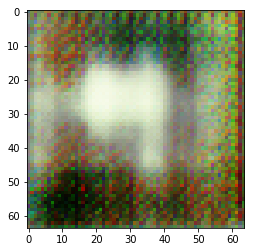

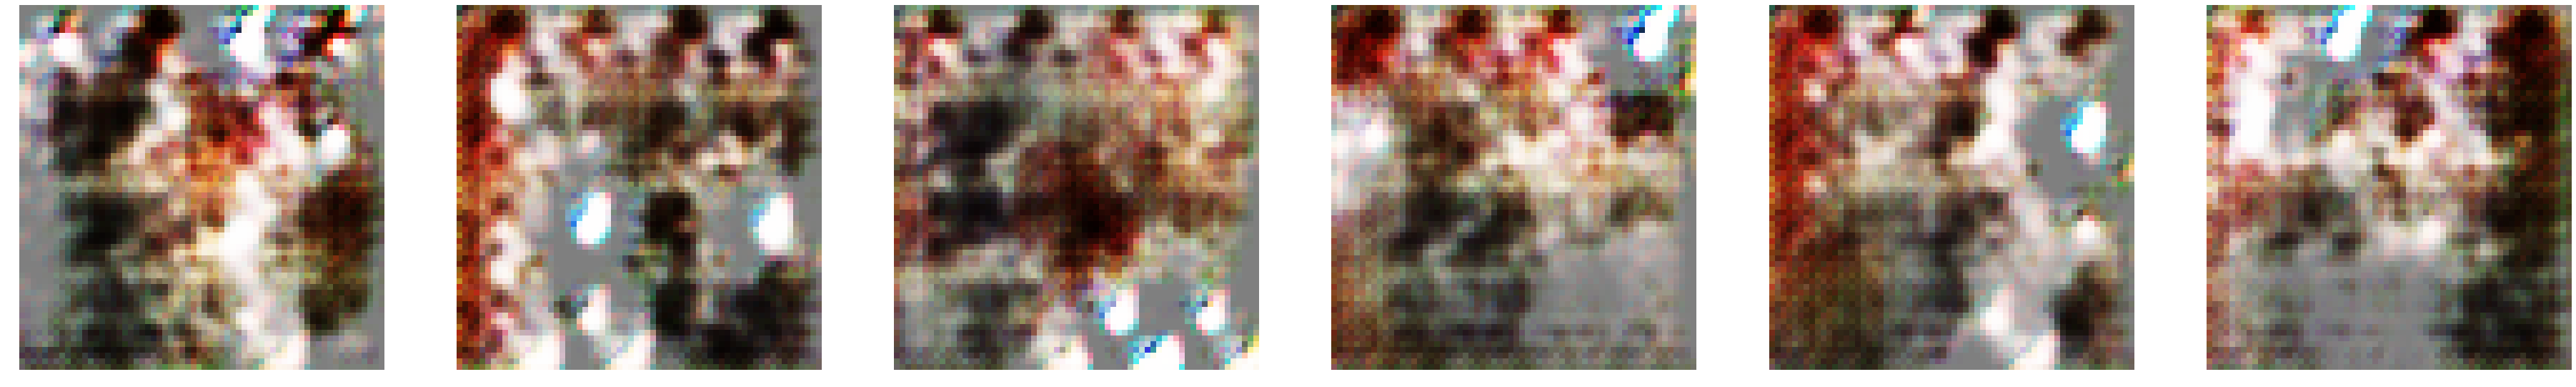

loss=rals 1epochの中での平均値 
 43.21s [12/301] Loss_D: 0.0743 Loss_G: 3.1216 outputR: -0.6248 outputF: -1.4395 / -1.5132
  最後のバッチのloss等 
    43.21s [12/301] Loss_D: 0.0749 Loss_G: 3.2953 outputR: -0.1825 outputF: -1.1180 / -1.1474
loss=rals 1epochの中での平均値 
 43.32s [13/301] Loss_D: 0.1127 Loss_G: 3.3026 outputR: -0.7449 outputF: -1.5135 / -1.6779
  最後のバッチのloss等 
    43.32s [13/301] Loss_D: 0.0626 Loss_G: 3.0209 outputR: -0.1997 outputF: -0.9244 / -1.0721
loss=rals 1epochの中での平均値 
 43.17s [14/301] Loss_D: 0.0834 Loss_G: 3.1237 outputR: -0.7204 outputF: -1.5258 / -1.6088
  最後のバッチのloss等 
    43.17s [14/301] Loss_D: 0.1345 Loss_G: 2.8832 outputR: -1.0911 outputF: -1.6381 / -1.9040
loss=rals 1epochの中での平均値 
 43.64s [15/301] Loss_D: 0.0625 Loss_G: 3.0704 outputR: -0.3514 outputF: -1.1808 / -1.2256
  最後のバッチのloss等 
    43.64s [15/301] Loss_D: 0.0110 Loss_G: 3.5373 outputR: -0.0738 outputF: -1.0497 / -1.0531
loss=rals 1epochの中での平均値 
 43.14s [16/301] Loss_D: 0.0437 Loss_G: 3.0004 outputR: -0.1777 outputF

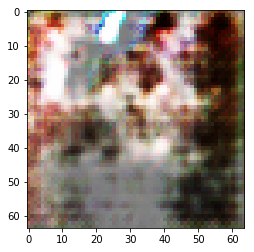

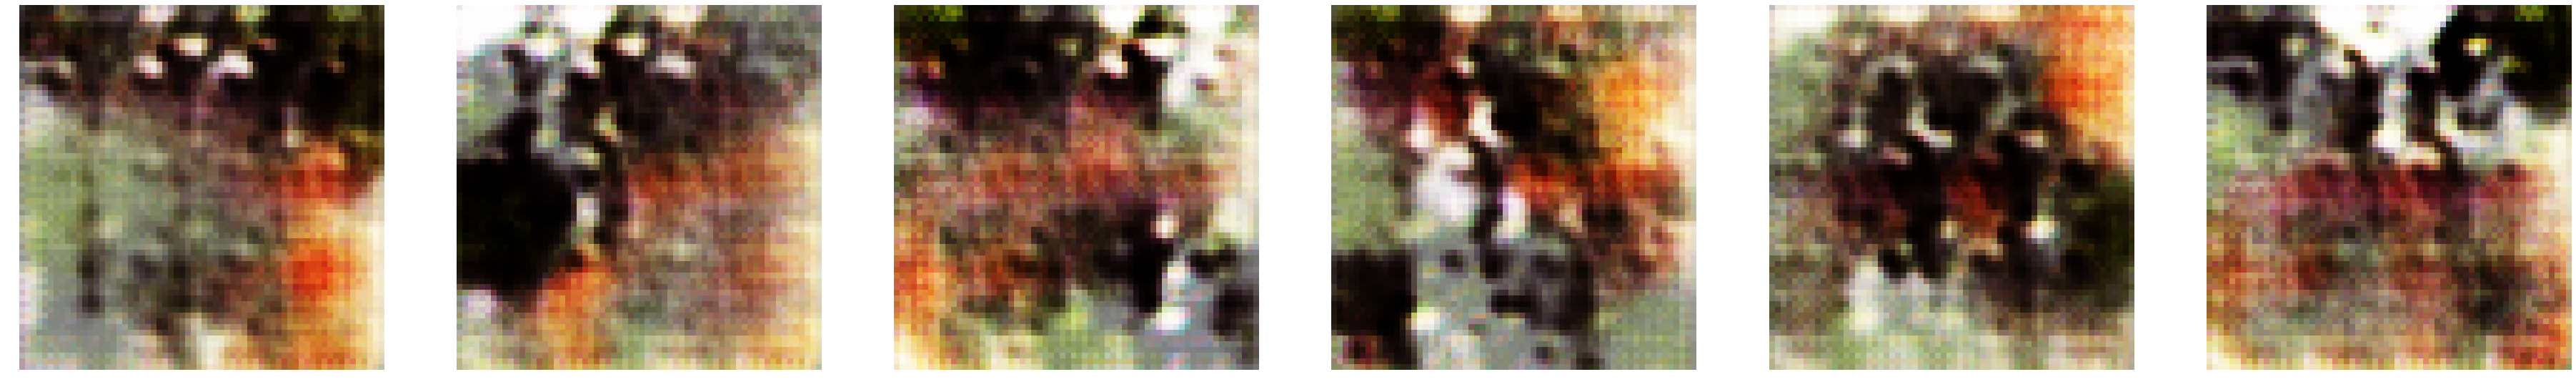

loss=rals 1epochの中での平均値 
 43.76s [22/301] Loss_D: 0.0657 Loss_G: 3.0387 outputR: -0.5322 outputF: -1.3558 / -1.3987
  最後のバッチのloss等 
    43.76s [22/301] Loss_D: 0.1162 Loss_G: 2.8063 outputR: -0.7233 outputF: -1.3029 / -1.5311
loss=rals 1epochの中での平均値 
 43.12s [23/301] Loss_D: 0.0610 Loss_G: 3.0280 outputR: -0.5517 outputF: -1.3790 / -1.4177
  最後のバッチのloss等 
    43.12s [23/301] Loss_D: 0.1035 Loss_G: 2.9818 outputR: -0.7349 outputF: -1.3363 / -1.6124
loss=rals 1epochの中での平均値 
 43.14s [24/301] Loss_D: 0.0598 Loss_G: 3.0290 outputR: -0.0764 outputF: -0.9075 / -0.9429
  最後のバッチのloss等 
    43.14s [24/301] Loss_D: 0.0073 Loss_G: 3.3353 outputR: 0.3208 outputF: -0.5368 / -0.6036
loss=rals 1epochの中での平均値 
 43.06s [25/301] Loss_D: 0.0755 Loss_G: 3.1638 outputR: -0.2176 outputF: -1.0247 / -1.1189
  最後のバッチのloss等 
    43.06s [25/301] Loss_D: 0.0370 Loss_G: 3.2403 outputR: -0.2293 outputF: -1.1019 / -1.1466
loss=rals 1epochの中での平均値 
 43.13s [26/301] Loss_D: 0.0864 Loss_G: 3.1800 outputR: -0.3168 outputF:

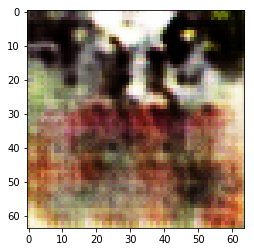

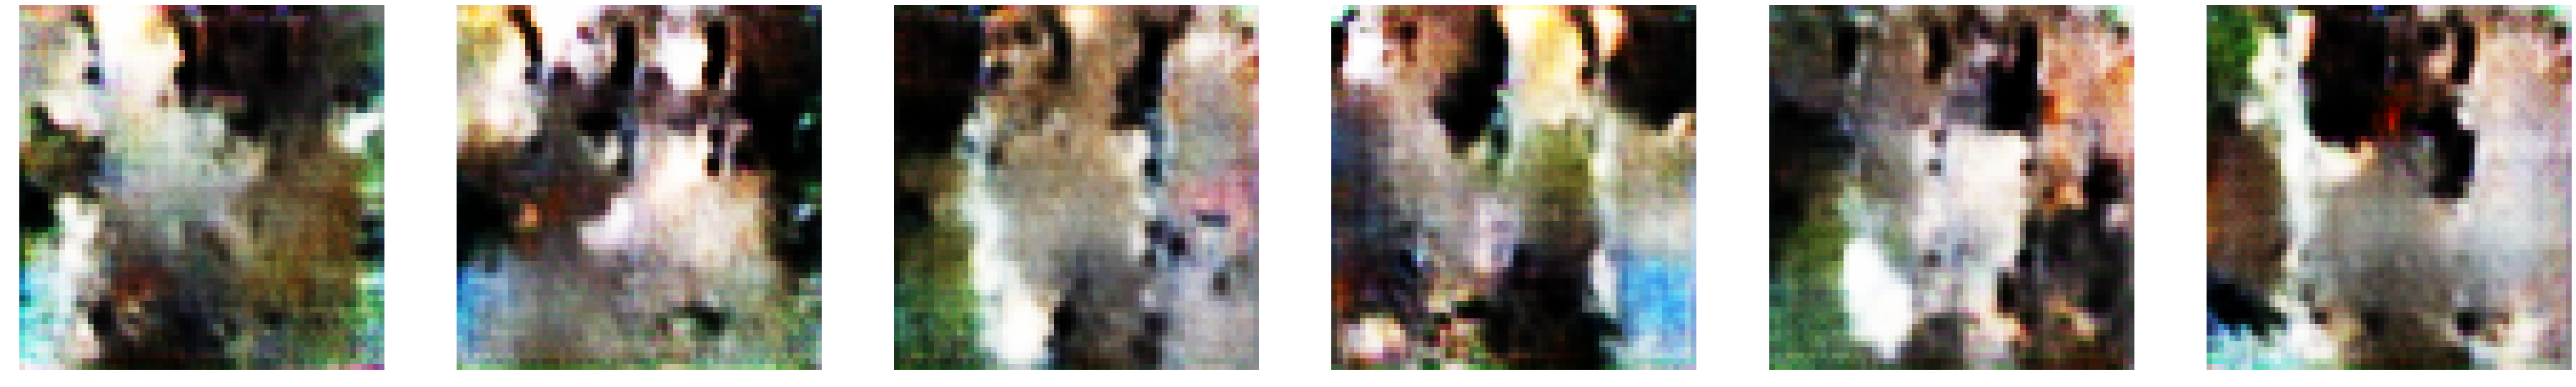

loss=rals 1epochの中での平均値 
 43.44s [32/301] Loss_D: 0.0783 Loss_G: 3.0520 outputR: -1.2461 outputF: -2.0504 / -2.1164
  最後のバッチのloss等 
    43.44s [32/301] Loss_D: 0.1308 Loss_G: 2.4689 outputR: -1.6777 outputF: -2.2407 / -2.3844
loss=rals 1epochの中での平均値 
 43.61s [33/301] Loss_D: 0.0713 Loss_G: 3.0654 outputR: -1.2833 outputF: -2.0994 / -2.1564
  最後のバッチのloss等 
    43.62s [33/301] Loss_D: 0.0428 Loss_G: 3.4230 outputR: -1.1065 outputF: -2.0997 / -2.0657
loss=rals 1epochの中での平均値 
 43.35s [34/301] Loss_D: 0.0711 Loss_G: 3.0734 outputR: -1.1828 outputF: -1.9957 / -2.0590
  最後のバッチのloss等 
    43.35s [34/301] Loss_D: 0.0360 Loss_G: 3.2818 outputR: -1.4558 outputF: -2.3821 / -2.3814
loss=rals 1epochの中での平均値 
 43.32s [35/301] Loss_D: 0.0720 Loss_G: 3.0955 outputR: -1.2176 outputF: -2.0303 / -2.0995
  最後のバッチのloss等 
    43.32s [35/301] Loss_D: 0.0964 Loss_G: 3.3675 outputR: -1.3977 outputF: -2.0012 / -2.3321
loss=rals 1epochの中での平均値 
 43.45s [36/301] Loss_D: 0.0743 Loss_G: 3.0606 outputR: -1.2536 outputF

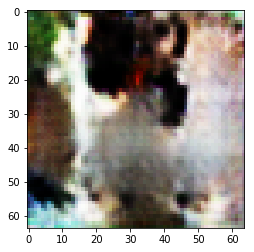

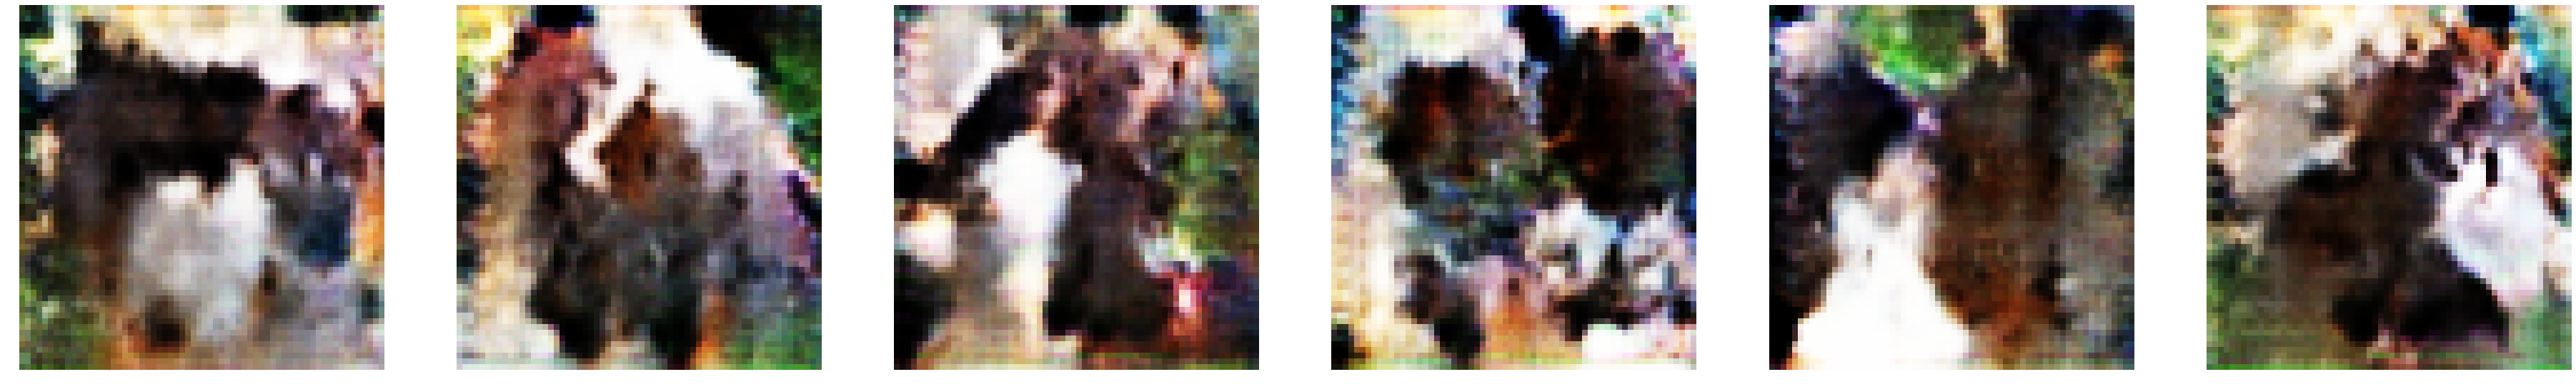

loss=rals 1epochの中での平均値 
 43.27s [42/301] Loss_D: 0.0771 Loss_G: 3.1228 outputR: -0.9837 outputF: -1.7916 / -1.8717
  最後のバッチのloss等 
    43.27s [42/301] Loss_D: 0.0532 Loss_G: 3.0687 outputR: -0.9542 outputF: -1.7666 / -1.8419
loss=rals 1epochの中での平均値 
 43.40s [43/301] Loss_D: 0.0756 Loss_G: 3.0701 outputR: -1.0238 outputF: -1.8346 / -1.8991
  最後のバッチのloss等 
    43.40s [43/301] Loss_D: 0.2283 Loss_G: 3.3834 outputR: -0.9924 outputF: -1.4332 / -1.9821
loss=rals 1epochの中での平均値 
 43.24s [44/301] Loss_D: 0.0763 Loss_G: 3.0819 outputR: -0.9316 outputF: -1.7417 / -1.8101
  最後のバッチのloss等 
    43.24s [44/301] Loss_D: 0.0610 Loss_G: 3.0417 outputR: -0.8127 outputF: -1.7815 / -1.6875
loss=rals 1epochの中での平均値 
 43.14s [45/301] Loss_D: 0.0732 Loss_G: 3.0845 outputR: -1.0826 outputF: -1.8940 / -1.9613
  最後のバッチのloss等 
    43.14s [45/301] Loss_D: 0.0728 Loss_G: 2.8235 outputR: -1.0685 outputF: -1.8121 / -1.8798
loss=rals 1epochの中での平均値 
 43.16s [46/301] Loss_D: 0.0652 Loss_G: 2.9999 outputR: -1.1470 outputF

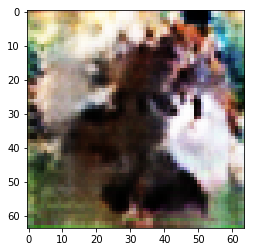

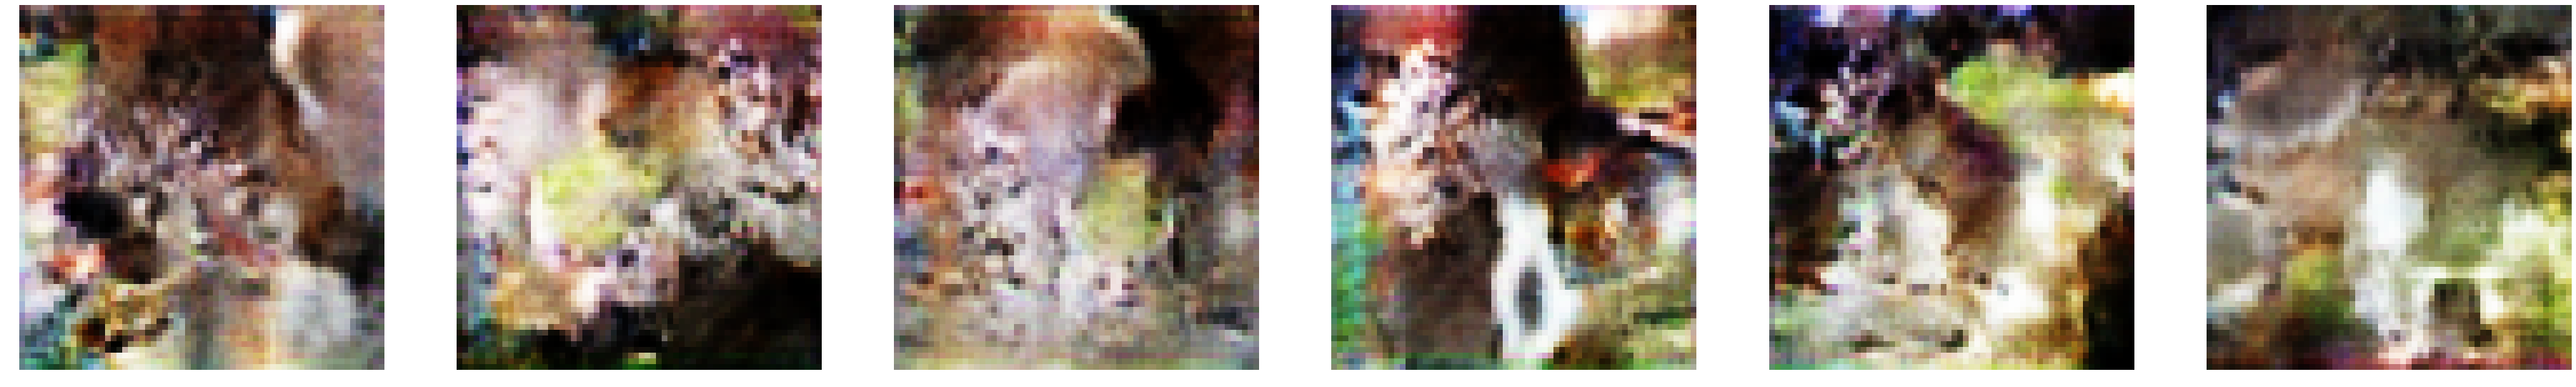

loss=rals 1epochの中での平均値 
 42.85s [52/301] Loss_D: 0.0680 Loss_G: 3.0460 outputR: -0.9677 outputF: -1.7880 / -1.8348
  最後のバッチのloss等 
    42.85s [52/301] Loss_D: 0.1573 Loss_G: 2.8049 outputR: -1.0594 outputF: -1.5710 / -1.8488
loss=rals 1epochの中での平均値 
 42.77s [53/301] Loss_D: 0.0677 Loss_G: 3.0479 outputR: -1.0047 outputF: -1.8223 / -1.8724
  最後のバッチのloss等 
    42.77s [53/301] Loss_D: 0.0525 Loss_G: 2.9932 outputR: -1.2013 outputF: -1.9555 / -2.0629
loss=rals 1epochの中での平均値 
 42.88s [54/301] Loss_D: 0.0684 Loss_G: 3.0585 outputR: -1.0173 outputF: -1.8371 / -1.8887
  最後のバッチのloss等 
    42.88s [54/301] Loss_D: 0.1334 Loss_G: 3.2837 outputR: -1.1463 outputF: -2.2210 / -2.1127
loss=rals 1epochの中での平均値 
 42.88s [55/301] Loss_D: 0.0707 Loss_G: 3.0322 outputR: -1.0084 outputF: -1.8248 / -1.8724
  最後のバッチのloss等 
    42.88s [55/301] Loss_D: 0.1119 Loss_G: 2.3963 outputR: -1.3644 outputF: -1.9526 / -2.0090
loss=rals 1epochの中での平均値 
 42.80s [56/301] Loss_D: 0.0689 Loss_G: 3.0567 outputR: -0.8378 outputF

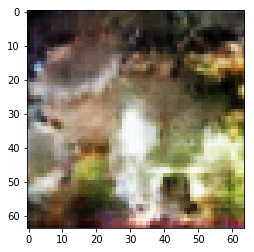

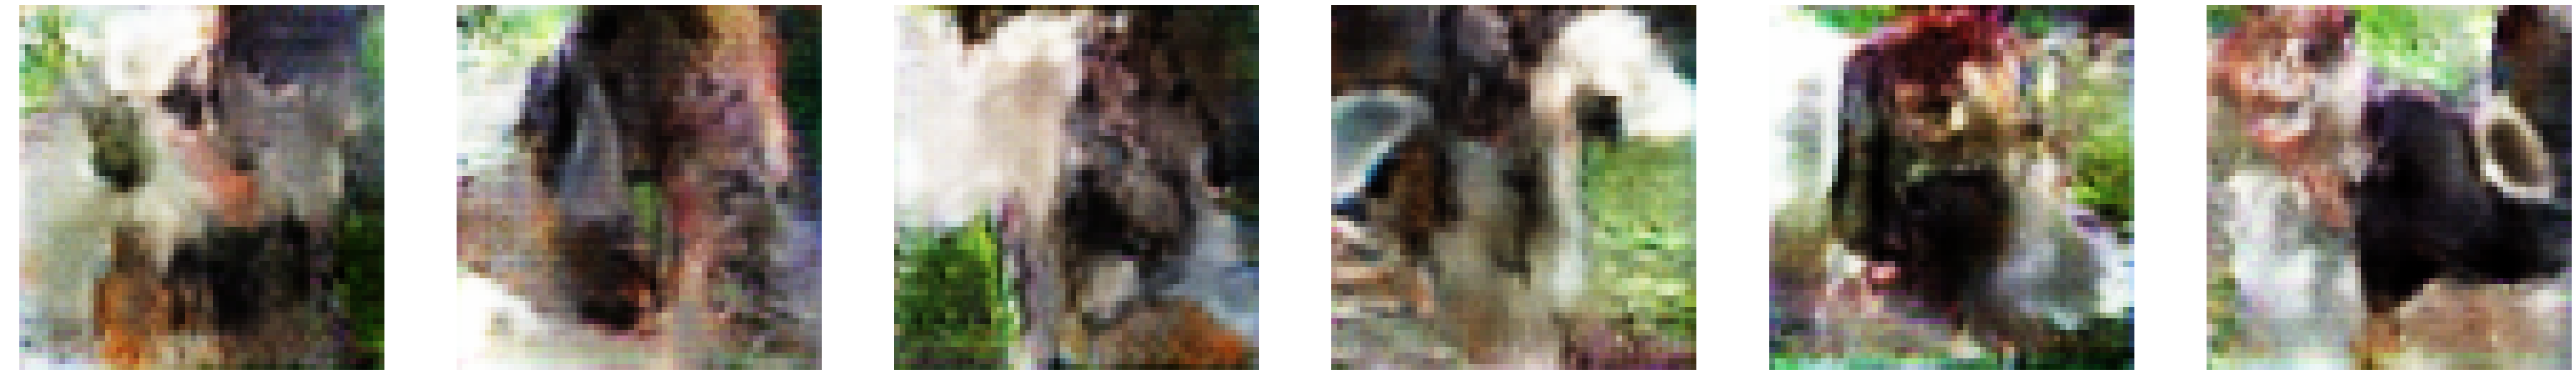

loss=rals 1epochの中での平均値 
 42.57s [62/301] Loss_D: 0.0606 Loss_G: 3.0044 outputR: -0.8215 outputF: -1.6463 / -1.6786
  最後のバッチのloss等 
    42.57s [62/301] Loss_D: 0.0327 Loss_G: 3.7206 outputR: -0.9148 outputF: -1.9566 / -1.9423
loss=rals 1epochの中での平均値 
 42.48s [63/301] Loss_D: 0.0620 Loss_G: 3.0130 outputR: -0.8584 outputF: -1.6833 / -1.7171
  最後のバッチのloss等 
    42.48s [63/301] Loss_D: 0.0368 Loss_G: 3.0965 outputR: -1.0467 outputF: -1.8925 / -1.9158
loss=rals 1epochの中での平均値 
 42.89s [64/301] Loss_D: 0.0645 Loss_G: 2.9905 outputR: -0.8699 outputF: -1.6920 / -1.7239
  最後のバッチのloss等 
    42.89s [64/301] Loss_D: 0.0128 Loss_G: 3.2177 outputR: -0.8926 outputF: -1.8424 / -1.7933
loss=rals 1epochの中での平均値 
 42.78s [65/301] Loss_D: 0.0614 Loss_G: 3.0125 outputR: -0.7966 outputF: -1.6228 / -1.6552
  最後のバッチのloss等 
    42.78s [65/301] Loss_D: 0.0348 Loss_G: 3.2150 outputR: -0.7517 outputF: -1.6776 / -1.6657
loss=rals 1epochの中での平均値 
 42.40s [66/301] Loss_D: 0.0629 Loss_G: 3.0119 outputR: -0.8472 outputF

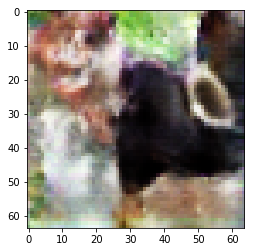

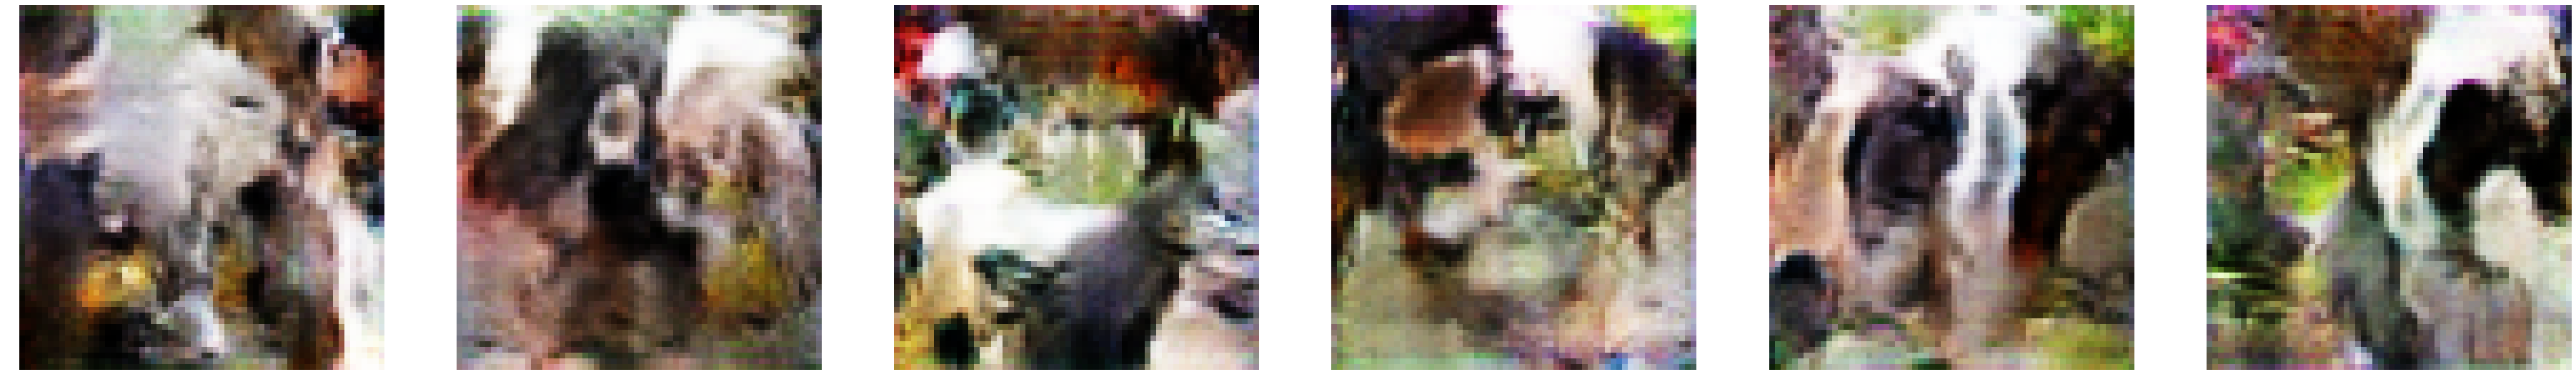

loss=rals 1epochの中での平均値 
 42.56s [72/301] Loss_D: 0.0667 Loss_G: 3.0360 outputR: -0.7496 outputF: -1.5702 / -1.6154
  最後のバッチのloss等 
    42.56s [72/301] Loss_D: 0.0971 Loss_G: 2.7533 outputR: -0.8521 outputF: -1.4725 / -1.6298
loss=rals 1epochの中での平均値 
 42.56s [73/301] Loss_D: 0.0702 Loss_G: 3.0161 outputR: -0.6932 outputF: -1.5104 / -1.5531
  最後のバッチのloss等 
    42.56s [73/301] Loss_D: 0.0353 Loss_G: 4.0731 outputR: -0.4178 outputF: -1.4788 / -1.5287
loss=rals 1epochの中での平均値 
 42.49s [74/301] Loss_D: 0.0673 Loss_G: 3.0304 outputR: -0.7096 outputF: -1.5286 / -1.5722
  最後のバッチのloss等 
    42.49s [74/301] Loss_D: 0.1546 Loss_G: 3.3419 outputR: -0.6734 outputF: -1.7928 / -1.6536
loss=rals 1epochの中での平均値 
 42.47s [75/301] Loss_D: 0.0693 Loss_G: 3.0237 outputR: -0.6640 outputF: -1.4819 / -1.5253
  最後のバッチのloss等 
    42.47s [75/301] Loss_D: 0.1056 Loss_G: 2.9994 outputR: -0.4295 outputF: -1.4513 / -1.3186
loss=rals 1epochの中での平均値 
 42.53s [76/301] Loss_D: 0.0575 Loss_G: 2.9864 outputR: -0.7545 outputF

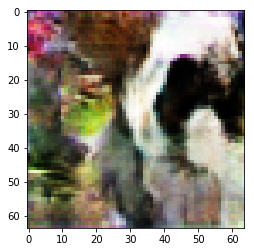

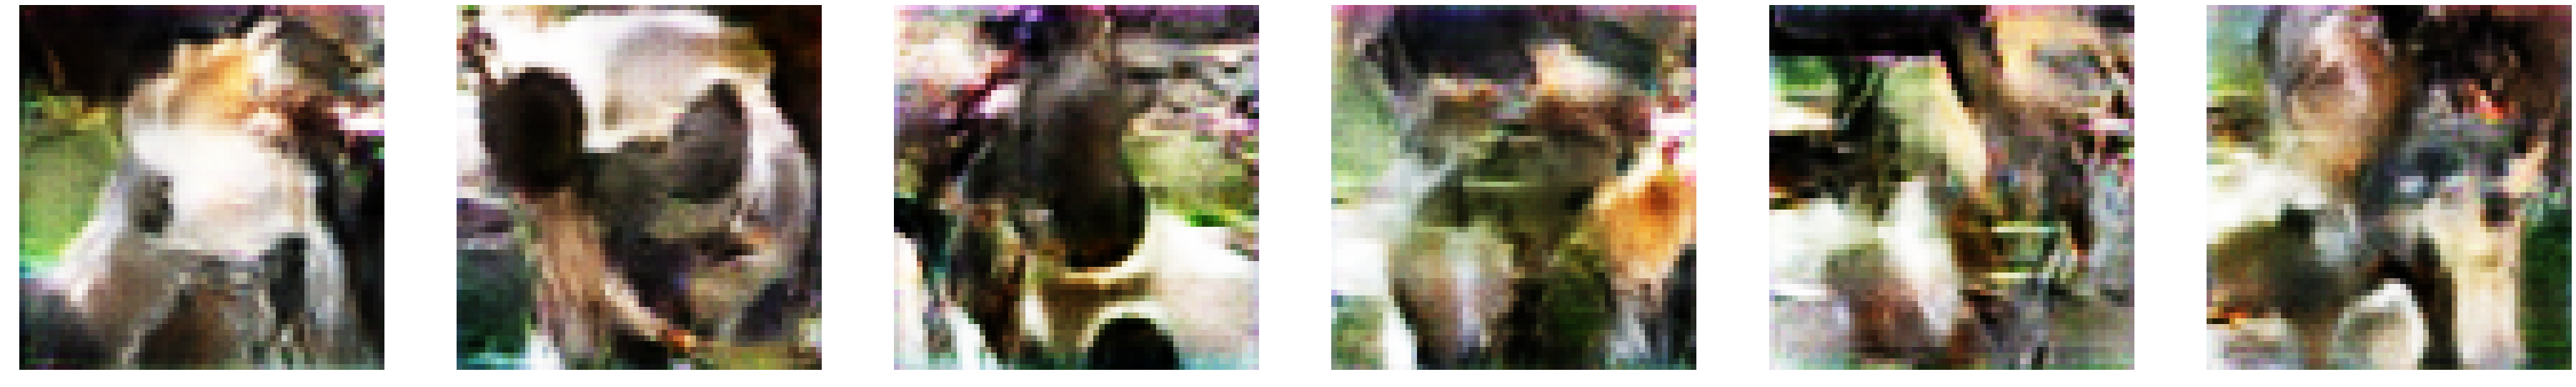

loss=rals 1epochの中での平均値 
 42.61s [82/301] Loss_D: 0.0646 Loss_G: 3.0159 outputR: -0.7113 outputF: -1.5339 / -1.5705
  最後のバッチのloss等 
    42.61s [82/301] Loss_D: 0.2097 Loss_G: 2.6128 outputR: -0.5265 outputF: -0.9892 / -1.2539
loss=rals 1epochの中での平均値 
 42.43s [83/301] Loss_D: 0.0665 Loss_G: 3.0023 outputR: -0.7569 outputF: -1.5747 / -1.6142
  最後のバッチのloss等 
    42.43s [83/301] Loss_D: 0.1074 Loss_G: 3.1629 outputR: -0.4465 outputF: -1.5028 / -1.3691
loss=rals 1epochの中での平均値 
 42.41s [84/301] Loss_D: 0.0689 Loss_G: 3.0023 outputR: -0.6798 outputF: -1.4973 / -1.5376
  最後のバッチのloss等 
    42.41s [84/301] Loss_D: 0.0103 Loss_G: 3.0736 outputR: -0.5908 outputF: -1.4379 / -1.4503
loss=rals 1epochの中での平均値 
 42.34s [85/301] Loss_D: 0.0709 Loss_G: 3.0023 outputR: -0.6681 outputF: -1.4826 / -1.5252
  最後のバッチのloss等 
    42.34s [85/301] Loss_D: 0.0793 Loss_G: 3.2693 outputR: -0.4601 outputF: -1.0864 / -1.3704
loss=rals 1epochの中での平均値 
 42.63s [86/301] Loss_D: 0.0699 Loss_G: 3.0112 outputR: -0.7015 outputF

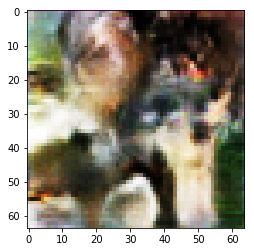

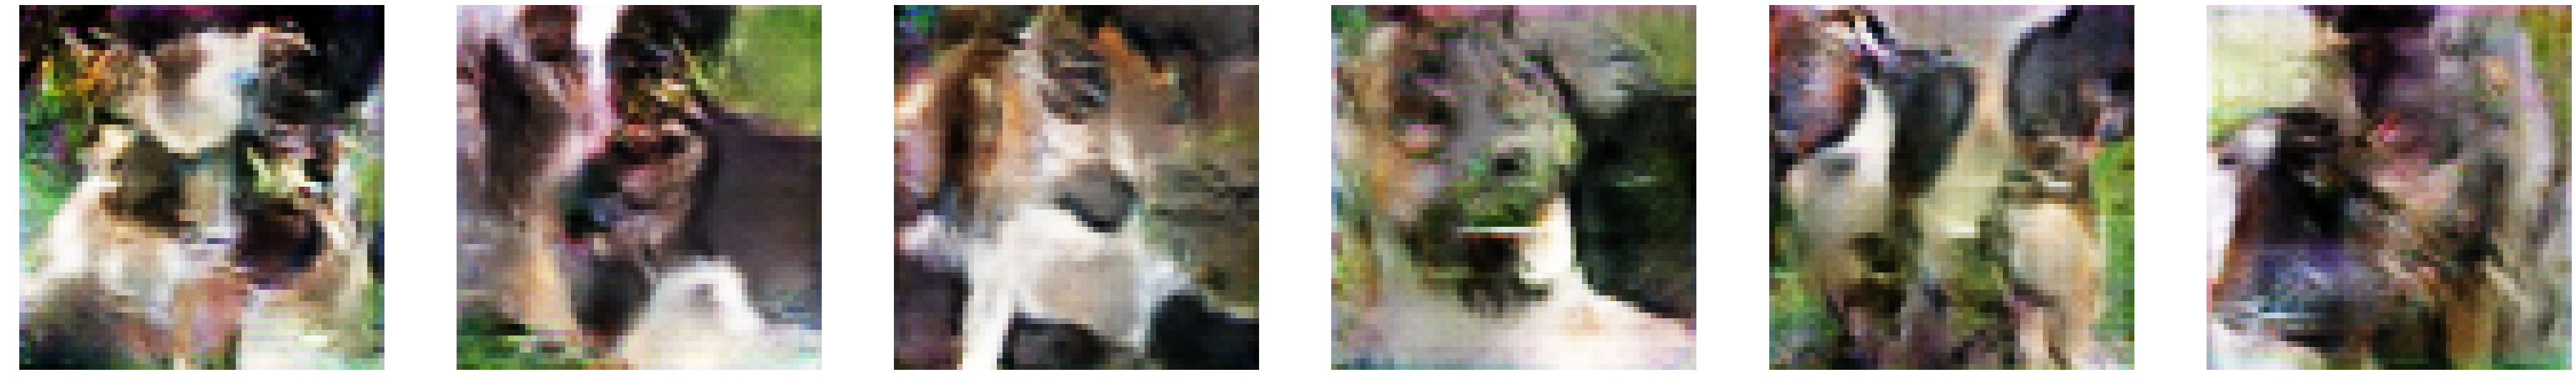

loss=rals 1epochの中での平均値 
 42.24s [92/301] Loss_D: 0.0593 Loss_G: 2.9859 outputR: -0.6178 outputF: -1.4446 / -1.4696
  最後のバッチのloss等 
    42.24s [92/301] Loss_D: 0.0472 Loss_G: 2.9877 outputR: -0.7075 outputF: -1.4208 / -1.5258
loss=rals 1epochの中での平均値 
 42.60s [93/301] Loss_D: 0.0620 Loss_G: 2.9842 outputR: -0.6882 outputF: -1.5113 / -1.5398
  最後のバッチのloss等 
    42.60s [93/301] Loss_D: 0.0975 Loss_G: 2.9298 outputR: -0.8720 outputF: -1.4757 / -1.6796
loss=rals 1epochの中での平均値 
 42.47s [94/301] Loss_D: 0.0611 Loss_G: 2.9975 outputR: -0.7121 outputF: -1.5390 / -1.5667
  最後のバッチのloss等 
    42.47s [94/301] Loss_D: 0.0371 Loss_G: 2.9865 outputR: -0.5876 outputF: -1.5681 / -1.4319
loss=rals 1epochの中での平均値 
 42.36s [95/301] Loss_D: 0.0597 Loss_G: 3.0005 outputR: -0.7035 outputF: -1.5291 / -1.5586
  最後のバッチのloss等 
    42.36s [95/301] Loss_D: 0.0601 Loss_G: 2.7154 outputR: -0.8927 outputF: -1.5746 / -1.6608
loss=rals 1epochの中での平均値 
 42.21s [96/301] Loss_D: 0.0627 Loss_G: 3.0041 outputR: -0.7075 outputF

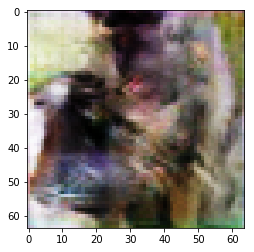

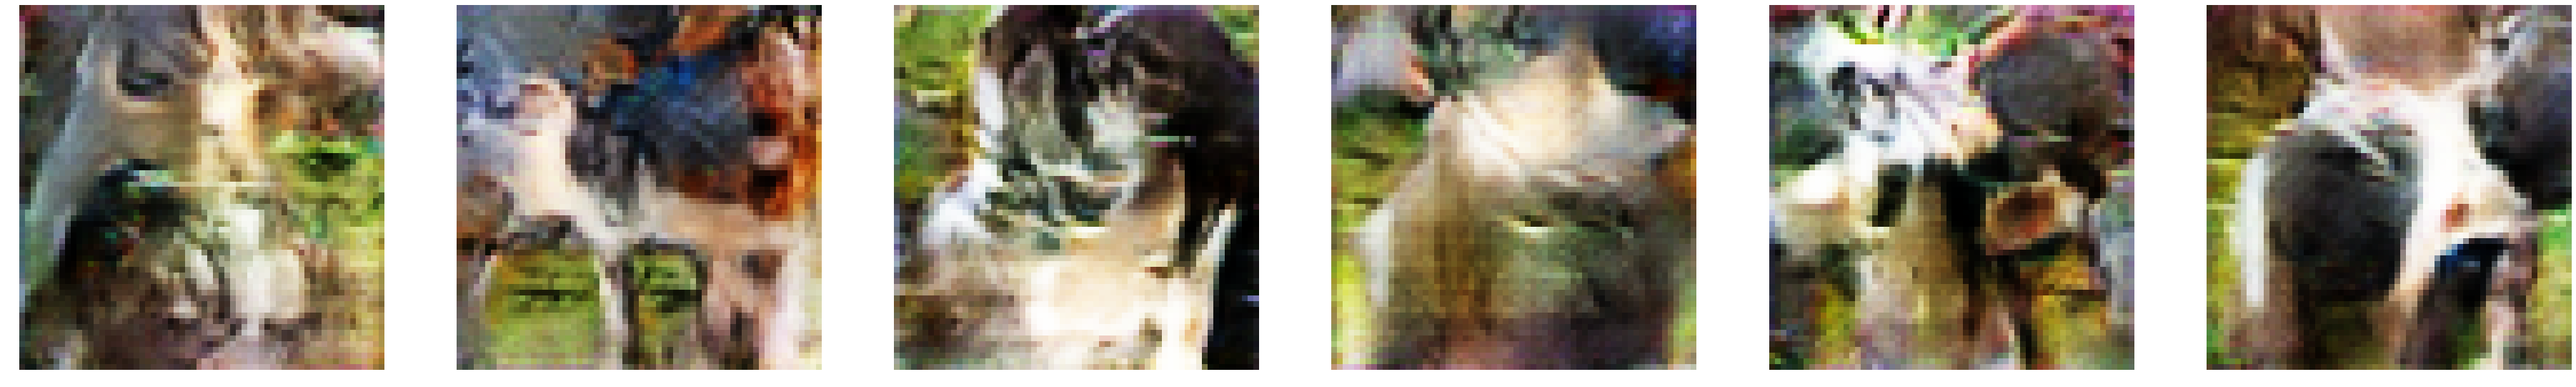

loss=rals 1epochの中での平均値 
 42.62s [102/301] Loss_D: 0.0658 Loss_G: 3.0103 outputR: -0.5379 outputF: -1.3616 / -1.3961
  最後のバッチのloss等 
    42.62s [102/301] Loss_D: 0.0189 Loss_G: 3.0027 outputR: -0.6637 outputF: -1.4625 / -1.4931
loss=rals 1epochの中での平均値 
 42.98s [103/301] Loss_D: 0.0635 Loss_G: 2.9935 outputR: -0.4094 outputF: -1.2334 / -1.2644
  最後のバッチのloss等 
    42.98s [103/301] Loss_D: 0.1089 Loss_G: 3.5178 outputR: -0.4875 outputF: -1.5410 / -1.5128
loss=rals 1epochの中での平均値 
 42.56s [104/301] Loss_D: 0.0679 Loss_G: 3.0009 outputR: -0.4335 outputF: -1.2532 / -1.2894
  最後のバッチのloss等 
    42.56s [104/301] Loss_D: 0.0107 Loss_G: 3.3737 outputR: -0.7448 outputF: -1.6934 / -1.6790
loss=rals 1epochの中での平均値 
 42.32s [105/301] Loss_D: 0.0651 Loss_G: 3.0076 outputR: -0.4145 outputF: -1.2370 / -1.2719
  最後のバッチのloss等 
    42.32s [105/301] Loss_D: 0.1005 Loss_G: 3.6318 outputR: -0.4770 outputF: -1.5647 / -1.5196
loss=rals 1epochの中での平均値 
 42.27s [106/301] Loss_D: 0.0547 Loss_G: 2.9775 outputR: -0.440

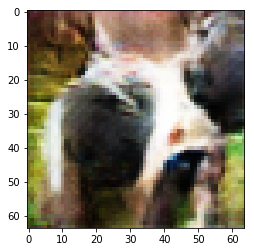

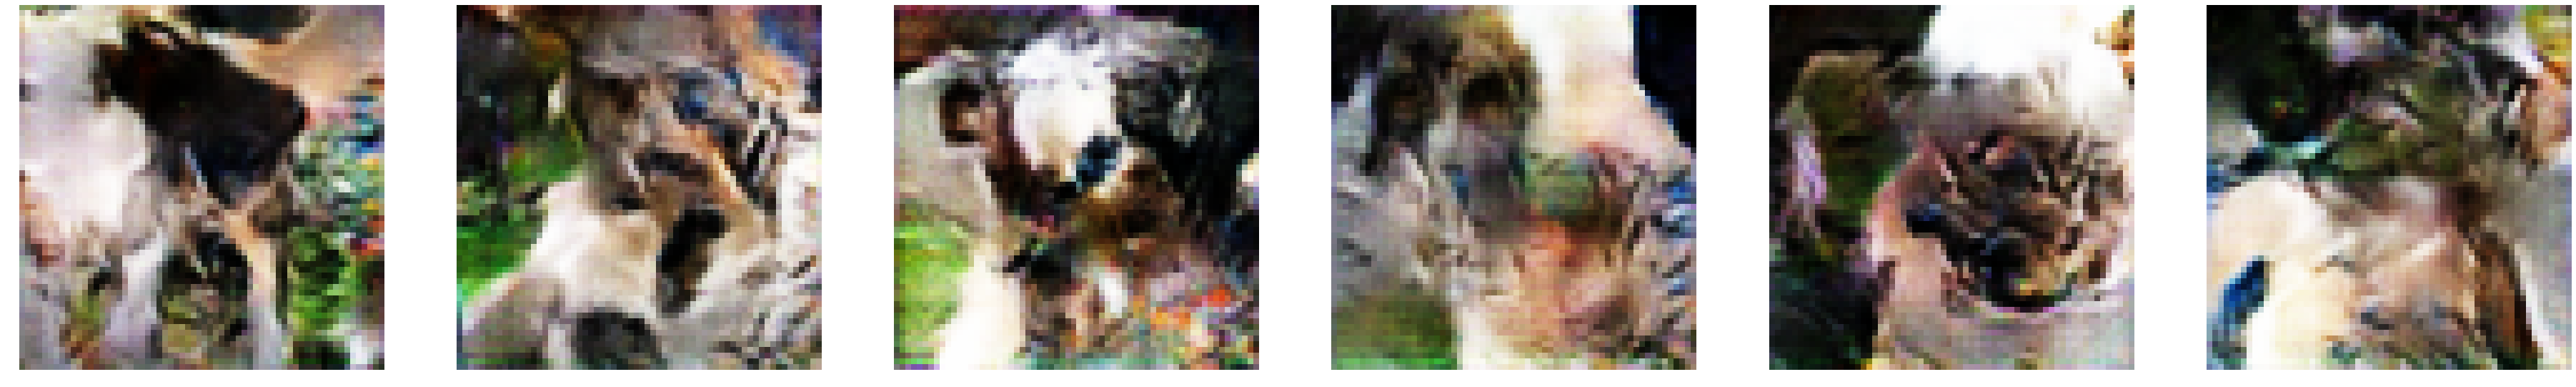

loss=rals 1epochの中での平均値 
 42.32s [112/301] Loss_D: 0.0566 Loss_G: 3.0035 outputR: -0.2790 outputF: -1.1126 / -1.1352
  最後のバッチのloss等 
    42.32s [112/301] Loss_D: 0.0311 Loss_G: 3.3553 outputR: -0.2119 outputF: -1.1660 / -1.1518
loss=rals 1epochの中での平均値 
 42.29s [113/301] Loss_D: 0.0598 Loss_G: 2.9895 outputR: -0.3019 outputF: -1.1292 / -1.1556
  最後のバッチのloss等 
    42.29s [113/301] Loss_D: 0.0509 Loss_G: 2.7367 outputR: -0.5614 outputF: -1.3325 / -1.3519
loss=rals 1epochの中での平均値 
 42.73s [114/301] Loss_D: 0.0577 Loss_G: 3.0164 outputR: -0.3323 outputF: -1.1643 / -1.1908
  最後のバッチのloss等 
    42.73s [114/301] Loss_D: 0.0462 Loss_G: 2.7723 outputR: -0.7514 outputF: -1.5089 / -1.5260
loss=rals 1epochの中での平均値 
 42.31s [115/301] Loss_D: 0.0594 Loss_G: 2.9965 outputR: -0.2535 outputF: -1.0832 / -1.1087
  最後のバッチのloss等 
    42.31s [115/301] Loss_D: 0.0883 Loss_G: 3.3310 outputR: -0.3784 outputF: -1.3678 / -1.3558
loss=rals 1epochの中での平均値 
 42.48s [116/301] Loss_D: 0.0570 Loss_G: 3.0016 outputR: -0.289

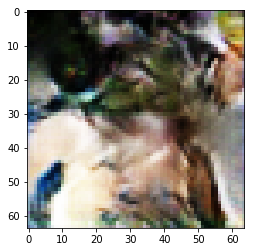

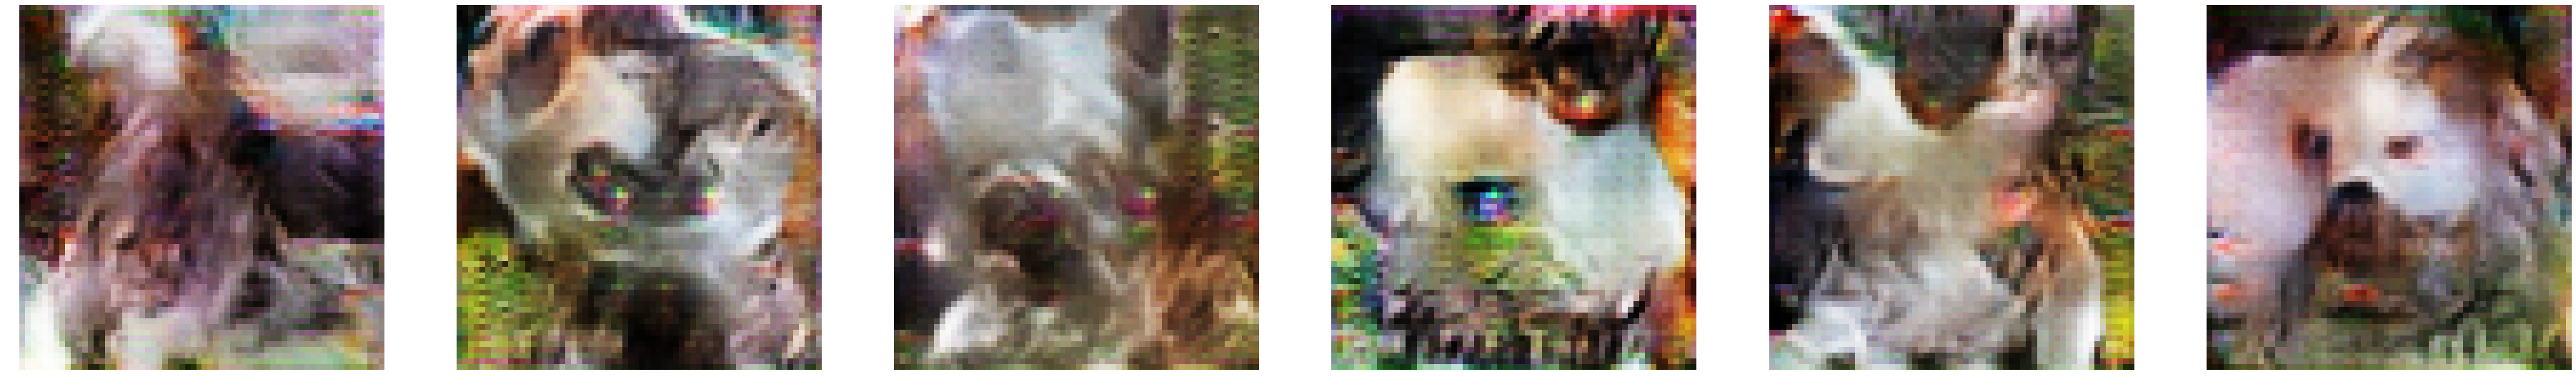

loss=rals 1epochの中での平均値 
 42.22s [122/301] Loss_D: 0.0479 Loss_G: 2.9854 outputR: -0.1242 outputF: -0.9653 / -0.9780
  最後のバッチのloss等 
    42.22s [122/301] Loss_D: 0.0228 Loss_G: 3.3134 outputR: -0.0907 outputF: -1.0022 / -1.0314
loss=rals 1epochの中での平均値 
 42.18s [123/301] Loss_D: 0.0507 Loss_G: 2.9823 outputR: -0.1163 outputF: -0.9561 / -0.9698
  最後のバッチのloss等 
    42.18s [123/301] Loss_D: 0.1358 Loss_G: 2.3263 outputR: -0.0190 outputF: -0.5605 / -0.7008
loss=rals 1epochの中での平均値 
 42.27s [124/301] Loss_D: 0.0471 Loss_G: 2.9944 outputR: -0.0585 outputF: -0.9015 / -0.9138
  最後のバッチのloss等 
    42.27s [124/301] Loss_D: 0.0575 Loss_G: 2.7854 outputR: -0.1320 outputF: -0.9423 / -0.9461
loss=rals 1epochの中での平均値 
 42.32s [125/301] Loss_D: 0.0497 Loss_G: 2.9993 outputR: -0.1109 outputF: -0.9496 / -0.9677
  最後のバッチのloss等 
    42.32s [125/301] Loss_D: 0.0310 Loss_G: 3.3960 outputR: -0.1444 outputF: -1.1158 / -1.1060
loss=rals 1epochの中での平均値 
 42.29s [126/301] Loss_D: 0.0503 Loss_G: 3.0014 outputR: -0.075

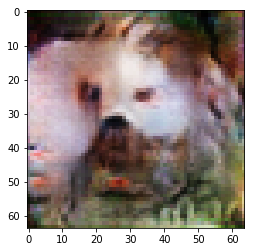

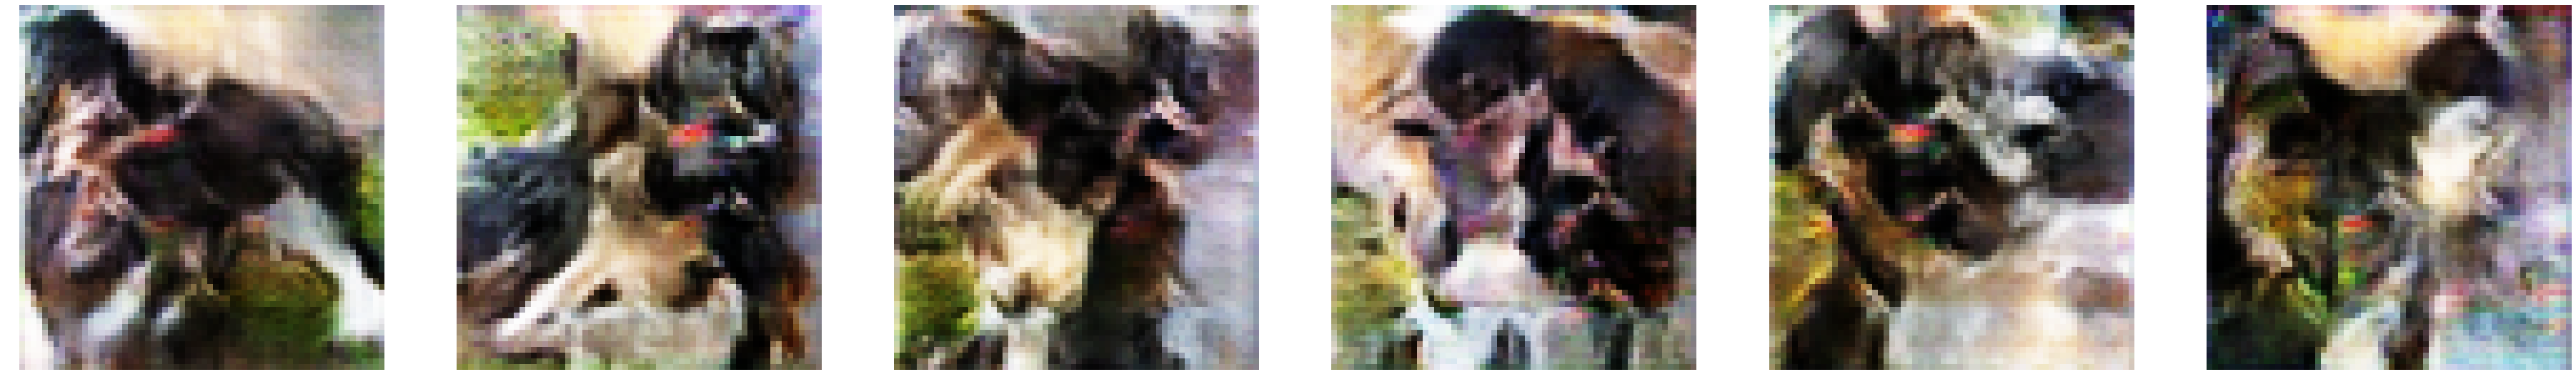

loss=rals 1epochの中での平均値 
 42.76s [132/301] Loss_D: 0.0452 Loss_G: 3.0327 outputR: 0.1482 outputF: -0.6986 / -0.7163
  最後のバッチのloss等 
    42.76s [132/301] Loss_D: 0.0530 Loss_G: 2.8803 outputR: 0.2050 outputF: -0.6592 / -0.6443
loss=rals 1epochの中での平均値 
 42.81s [133/301] Loss_D: 0.0449 Loss_G: 3.0183 outputR: 0.1961 outputF: -0.6515 / -0.6658
  最後のバッチのloss等 
    42.81s [133/301] Loss_D: 0.0763 Loss_G: 3.3847 outputR: 0.4011 outputF: -0.6402 / -0.5781
loss=rals 1epochの中での平均値 
 42.84s [134/301] Loss_D: 0.0483 Loss_G: 3.0007 outputR: 0.2156 outputF: -0.6249 / -0.6431
  最後のバッチのloss等 
    42.84s [134/301] Loss_D: 0.0205 Loss_G: 3.0157 outputR: 0.1488 outputF: -0.7117 / -0.7077
loss=rals 1epochの中での平均値 
 43.03s [135/301] Loss_D: 0.0506 Loss_G: 3.0066 outputR: 0.1687 outputF: -0.6701 / -0.6923
  最後のバッチのloss等 
    43.03s [135/301] Loss_D: 0.0636 Loss_G: 2.6461 outputR: 0.1575 outputF: -0.5299 / -0.5768
loss=rals 1epochの中での平均値 
 42.79s [136/301] Loss_D: 0.0417 Loss_G: 2.9992 outputR: 0.2303 outputF

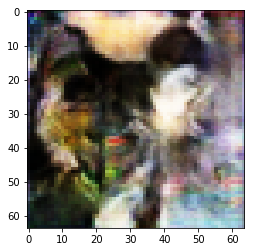

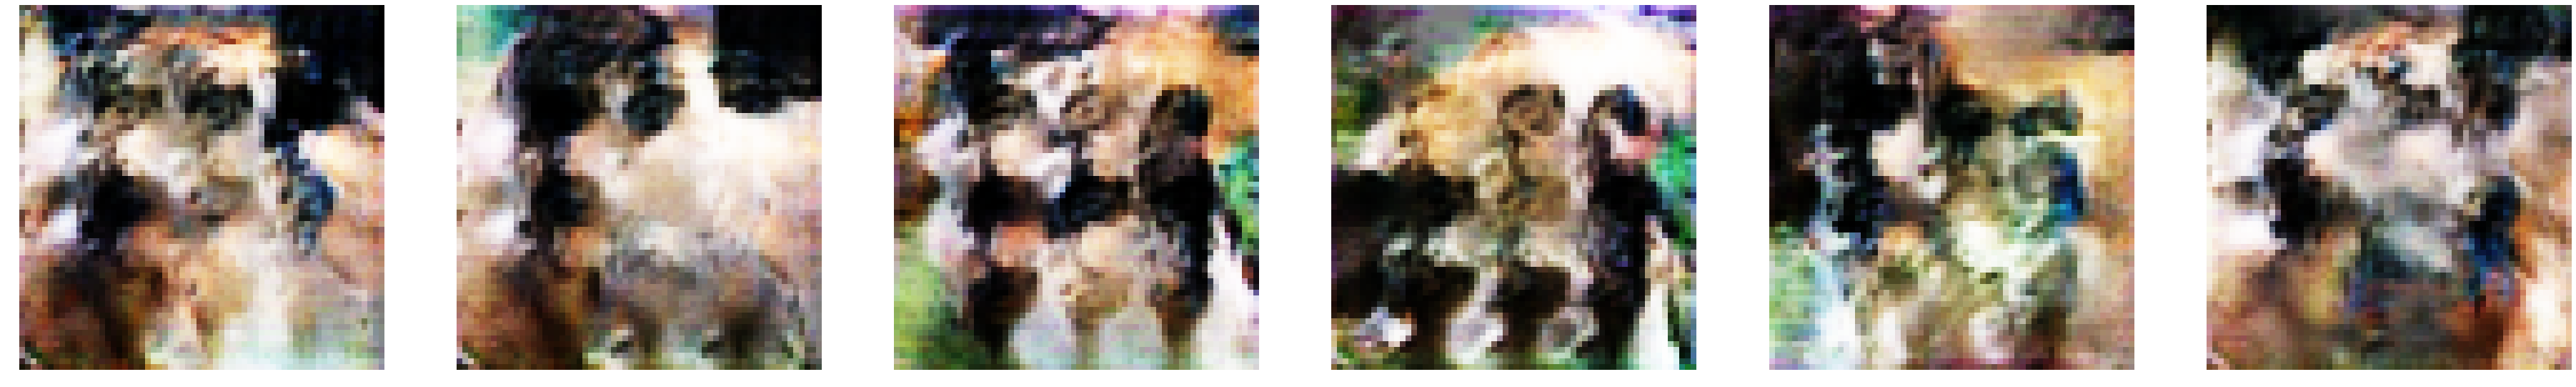

loss=rals 1epochの中での平均値 
 43.04s [142/301] Loss_D: 0.0416 Loss_G: 3.0131 outputR: 0.2671 outputF: -0.5815 / -0.5953
  最後のバッチのloss等 
    43.04s [142/301] Loss_D: 0.0059 Loss_G: 3.4179 outputR: 0.3630 outputF: -0.5954 / -0.5862
loss=rals 1epochの中での平均値 
 42.81s [143/301] Loss_D: 0.0430 Loss_G: 3.0057 outputR: 0.2949 outputF: -0.5516 / -0.5667
  最後のバッチのloss等 
    42.81s [143/301] Loss_D: 0.0837 Loss_G: 3.4212 outputR: 0.3180 outputF: -0.6789 / -0.6877
loss=rals 1epochの中での平均値 
 42.89s [144/301] Loss_D: 0.0395 Loss_G: 3.0118 outputR: 0.3561 outputF: -0.4961 / -0.5066
  最後のバッチのloss等 
    42.89s [144/301] Loss_D: 0.0044 Loss_G: 3.4409 outputR: 0.5018 outputF: -0.4495 / -0.4464
loss=rals 1epochの中での平均値 
 42.90s [145/301] Loss_D: 0.0388 Loss_G: 3.0206 outputR: 0.3981 outputF: -0.4546 / -0.4668
  最後のバッチのloss等 
    42.90s [145/301] Loss_D: 0.0233 Loss_G: 3.0704 outputR: 0.4732 outputF: -0.3896 / -0.3874
loss=rals 1epochの中での平均値 
 42.88s [146/301] Loss_D: 0.0376 Loss_G: 3.0198 outputR: 0.4311 outputF

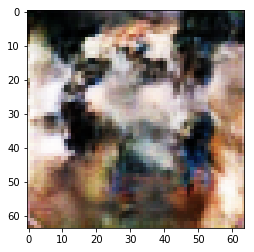

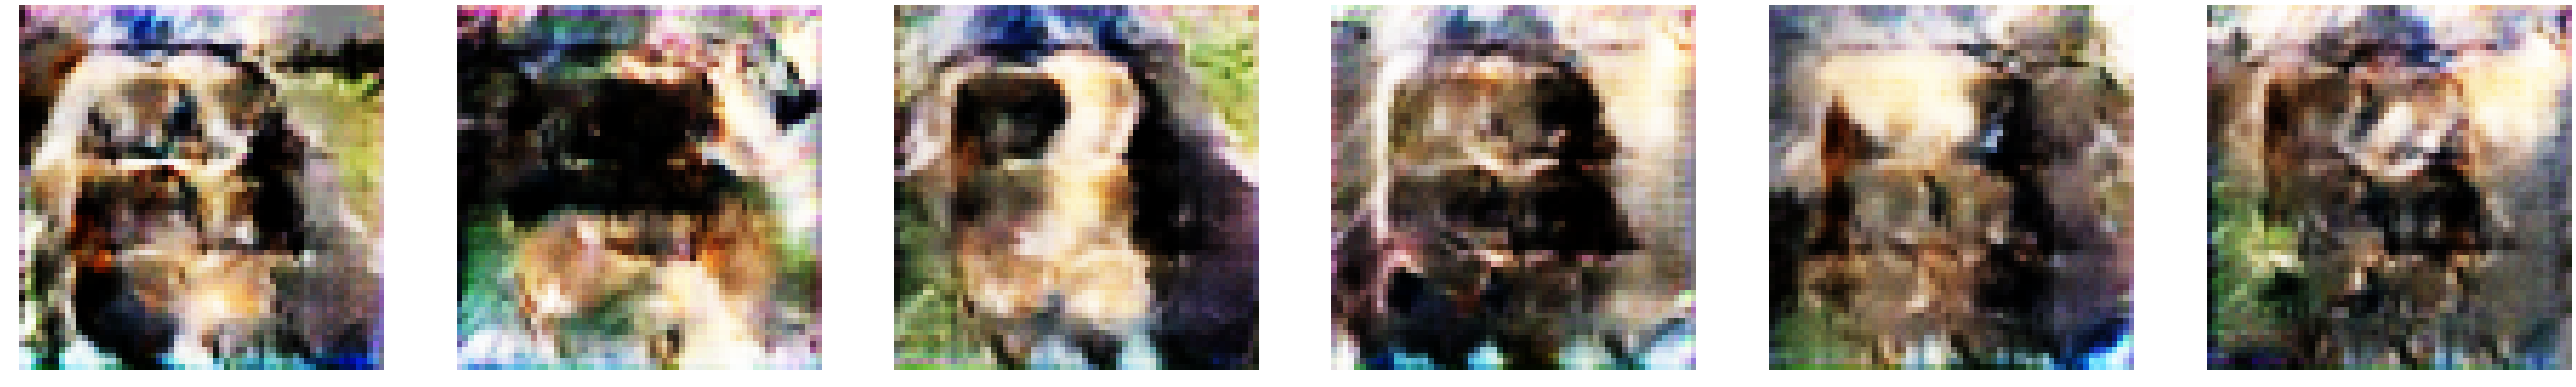

loss=rals 1epochの中での平均値 
 42.87s [152/301] Loss_D: 0.0335 Loss_G: 3.0162 outputR: 0.5408 outputF: -0.3178 / -0.3231
  最後のバッチのloss等 
    42.88s [152/301] Loss_D: 0.0388 Loss_G: 2.8587 outputR: 0.5752 outputF: -0.2489 / -0.2504
loss=rals 1epochの中での平均値 
 42.96s [153/301] Loss_D: 0.0344 Loss_G: 3.0064 outputR: 0.5377 outputF: -0.3199 / -0.3251
  最後のバッチのloss等 
    42.96s [153/301] Loss_D: 0.0601 Loss_G: 2.9331 outputR: 0.5767 outputF: -0.3067 / -0.2943
loss=rals 1epochの中での平均値 
 42.84s [154/301] Loss_D: 0.0351 Loss_G: 3.0113 outputR: 0.5345 outputF: -0.3220 / -0.3286
  最後のバッチのloss等 
    42.85s [154/301] Loss_D: 0.0032 Loss_G: 3.0587 outputR: 0.5929 outputF: -0.2597 / -0.2600
loss=rals 1epochの中での平均値 
 42.80s [155/301] Loss_D: 0.0353 Loss_G: 3.0244 outputR: 0.5412 outputF: -0.3153 / -0.3254
  最後のバッチのloss等 
    42.80s [155/301] Loss_D: 0.0198 Loss_G: 2.9888 outputR: 0.4978 outputF: -0.3628 / -0.3579
loss=rals 1epochの中での平均値 
 42.85s [156/301] Loss_D: 0.0456 Loss_G: 3.0249 outputR: 0.4174 outputF

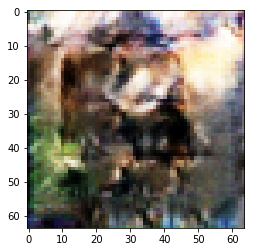

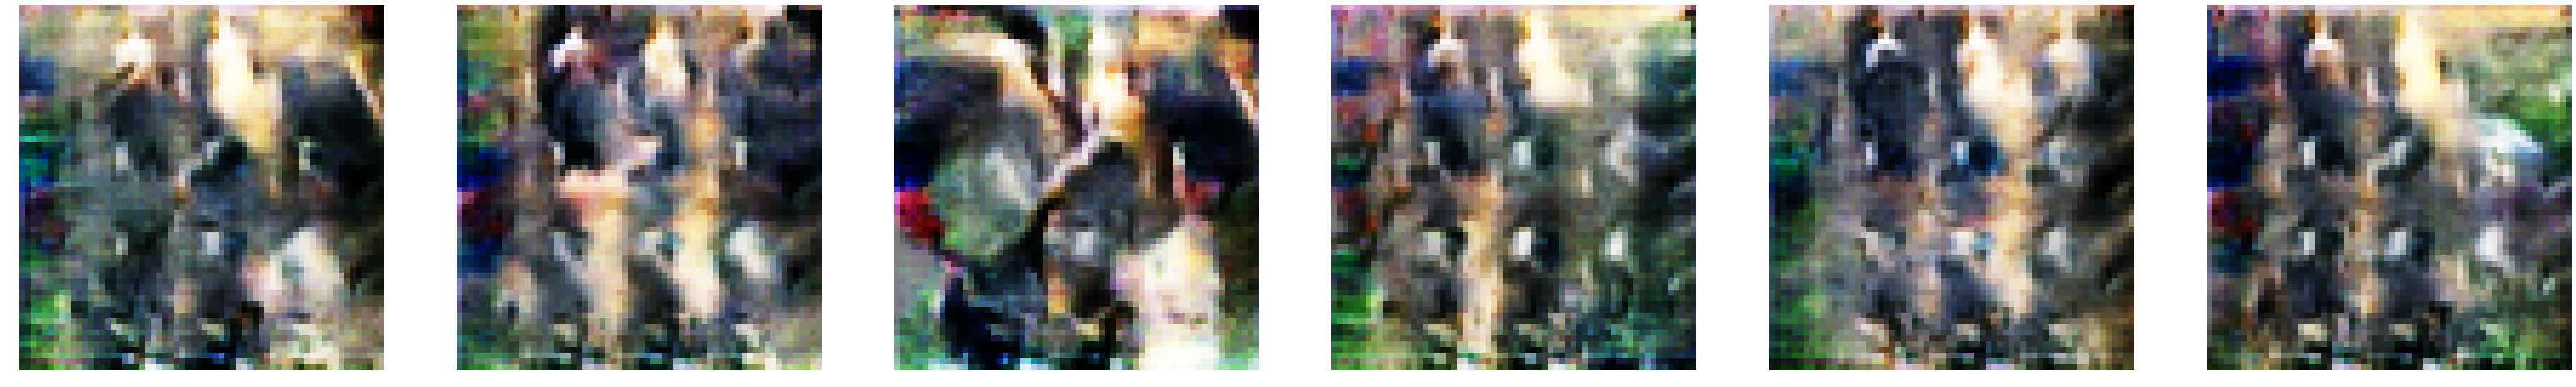

loss=rals 1epochの中での平均値 
 42.95s [162/301] Loss_D: 0.0401 Loss_G: 3.0337 outputR: 0.5891 outputF: -0.2622 / -0.2790
  最後のバッチのloss等 
    42.95s [162/301] Loss_D: 0.0780 Loss_G: 2.7343 outputR: 0.5375 outputF: -0.4359 / -0.2760
loss=rals 1epochの中での平均値 
 43.06s [163/301] Loss_D: 0.0412 Loss_G: 3.0237 outputR: 0.5355 outputF: -0.3128 / -0.3318
  最後のバッチのloss等 
    43.06s [163/301] Loss_D: 0.0721 Loss_G: 3.2226 outputR: 0.7082 outputF: -0.2550 / -0.2482
loss=rals 1epochの中での平均値 
 43.32s [164/301] Loss_D: 0.0364 Loss_G: 3.0266 outputR: 0.6388 outputF: -0.2166 / -0.2277
  最後のバッチのloss等 
    43.32s [164/301] Loss_D: 0.0401 Loss_G: 2.8661 outputR: 0.6603 outputF: -0.1687 / -0.1690
loss=rals 1epochの中での平均値 
 42.96s [165/301] Loss_D: 0.0346 Loss_G: 3.0200 outputR: 0.6819 outputF: -0.1760 / -0.1837
  最後のバッチのloss等 
    42.96s [165/301] Loss_D: 0.0582 Loss_G: 2.7411 outputR: 0.6809 outputF: -0.1460 / -0.1445
loss=rals 1epochの中での平均値 
 42.98s [166/301] Loss_D: 0.0384 Loss_G: 3.0088 outputR: 0.6540 outputF

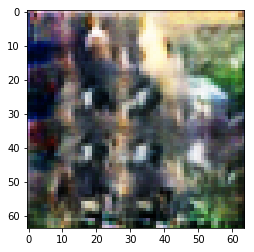

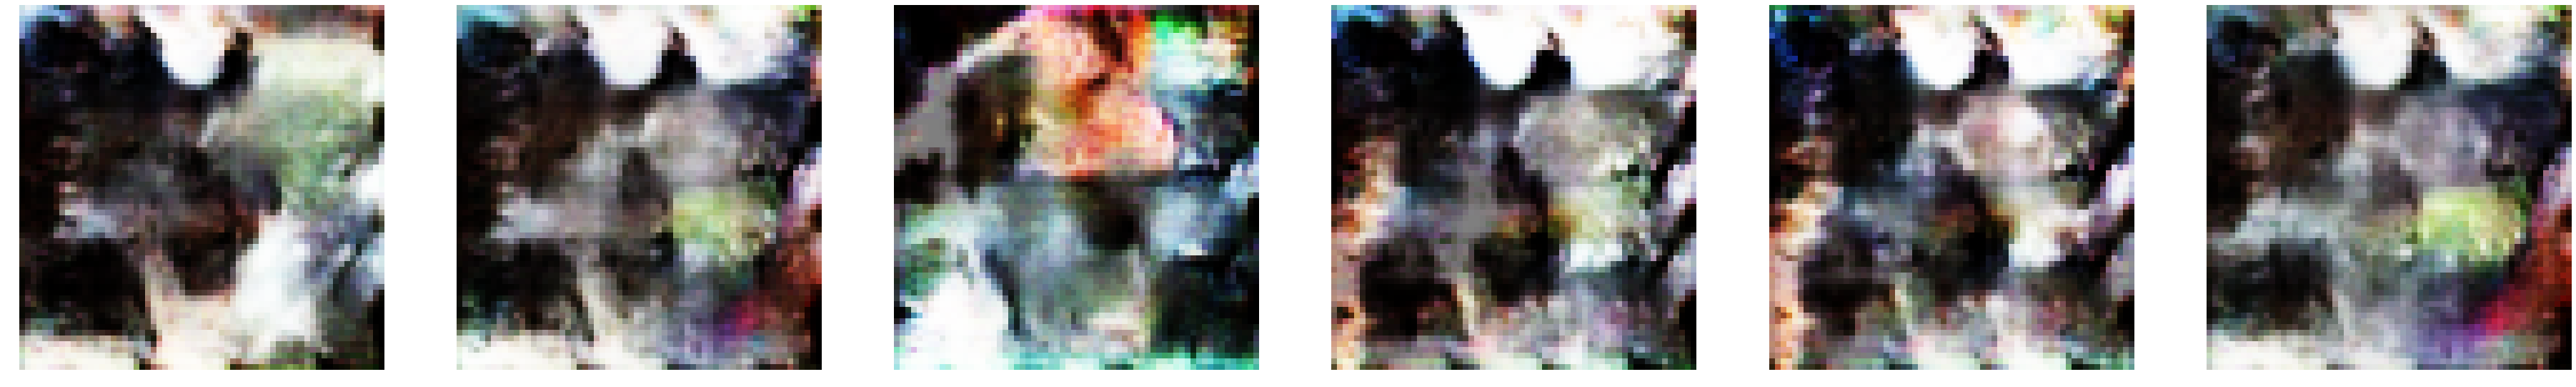

loss=rals 1epochの中での平均値 
 42.91s [172/301] Loss_D: 0.0466 Loss_G: 3.0523 outputR: 0.5450 outputF: -0.2940 / -0.3277
  最後のバッチのloss等 
    42.91s [172/301] Loss_D: 0.0449 Loss_G: 2.9183 outputR: 0.1767 outputF: -0.6342 / -0.6657
loss=rals 1epochの中での平均値 
 42.70s [173/301] Loss_D: 0.0438 Loss_G: 3.0205 outputR: 0.5924 outputF: -0.2549 / -0.2734
  最後のバッチのloss等 
    42.70s [173/301] Loss_D: 0.0271 Loss_G: 3.3667 outputR: 0.6098 outputF: -0.3505 / -0.3439
loss=rals 1epochの中での平均値 
 42.89s [174/301] Loss_D: 0.0391 Loss_G: 3.0343 outputR: 0.6289 outputF: -0.2241 / -0.2395
  最後のバッチのloss等 
    42.89s [174/301] Loss_D: 0.0422 Loss_G: 2.7761 outputR: 0.6091 outputF: -0.1950 / -0.1955
loss=rals 1epochの中での平均値 
 42.84s [175/301] Loss_D: 0.0420 Loss_G: 3.0193 outputR: 0.6340 outputF: -0.2137 / -0.2316
  最後のバッチのloss等 
    42.84s [175/301] Loss_D: 0.0522 Loss_G: 3.0897 outputR: 0.6067 outputF: -0.3251 / -0.2960
loss=rals 1epochの中での平均値 
 42.79s [176/301] Loss_D: 0.0420 Loss_G: 3.0266 outputR: 0.6283 outputF

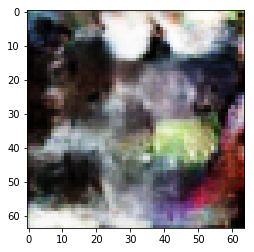

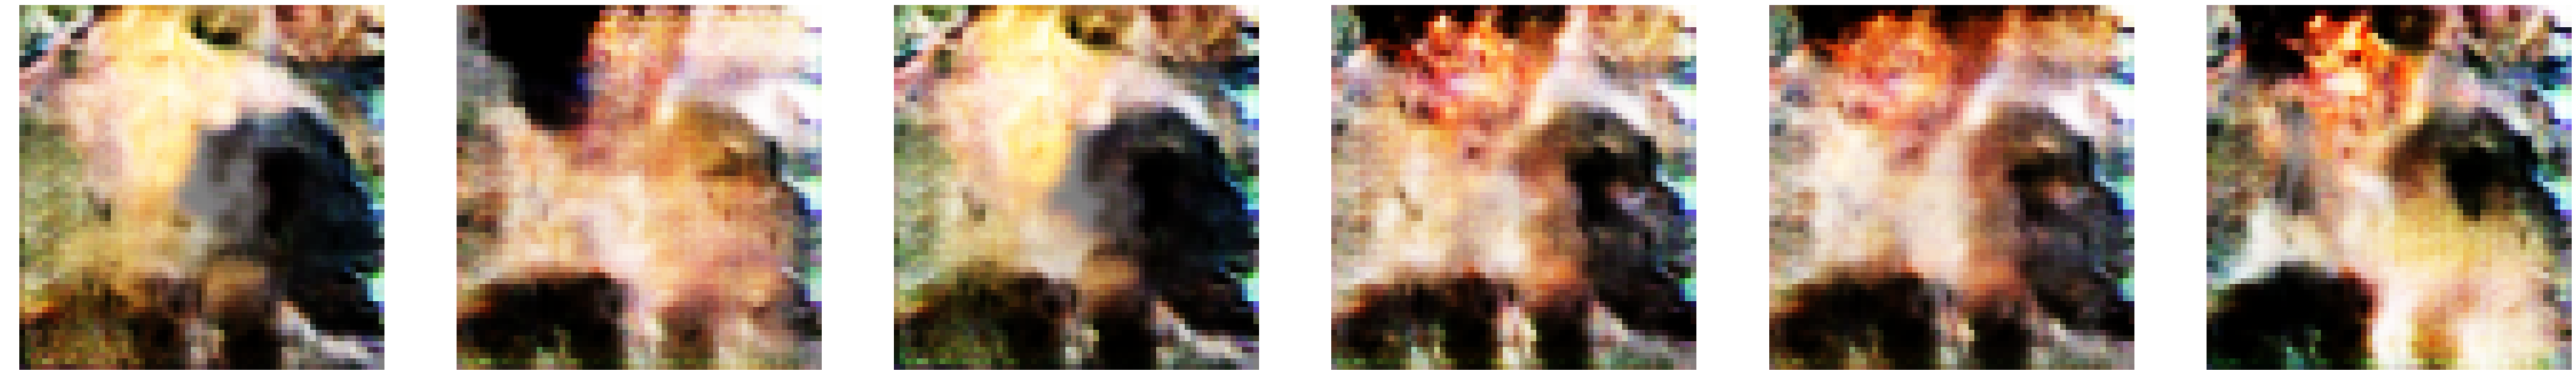

loss=rals 1epochの中での平均値 
 42.79s [182/301] Loss_D: 0.0362 Loss_G: 3.0184 outputR: 0.7008 outputF: -0.1550 / -0.1634
  最後のバッチのloss等 
    42.79s [182/301] Loss_D: 0.0549 Loss_G: 2.9504 outputR: 0.8179 outputF: -0.0630 / -0.0560
loss=rals 1epochの中での平均値 
 42.76s [183/301] Loss_D: 0.0430 Loss_G: 3.0269 outputR: 0.6755 outputF: -0.1681 / -0.1919
  最後のバッチのloss等 
    42.76s [183/301] Loss_D: 0.0229 Loss_G: 3.0864 outputR: 0.6598 outputF: -0.1985 / -0.2023
loss=rals 1epochの中での平均値 
 42.68s [184/301] Loss_D: 0.0420 Loss_G: 3.0408 outputR: 0.6089 outputF: -0.2397 / -0.2606
  最後のバッチのloss等 
    42.68s [184/301] Loss_D: 0.0455 Loss_G: 3.1508 outputR: 0.5714 outputF: -0.3520 / -0.3470
loss=rals 1epochの中での平均値 
 43.03s [185/301] Loss_D: 0.0524 Loss_G: 3.0270 outputR: 0.4175 outputF: -0.4092 / -0.4493
  最後のバッチのloss等 
    43.03s [185/301] Loss_D: 0.0247 Loss_G: 2.8542 outputR: 0.5128 outputF: -0.3157 / -0.3052
loss=rals 1epochの中での平均値 
 42.69s [186/301] Loss_D: 0.0461 Loss_G: 3.0302 outputR: 0.5794 outputF

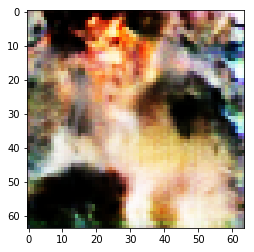

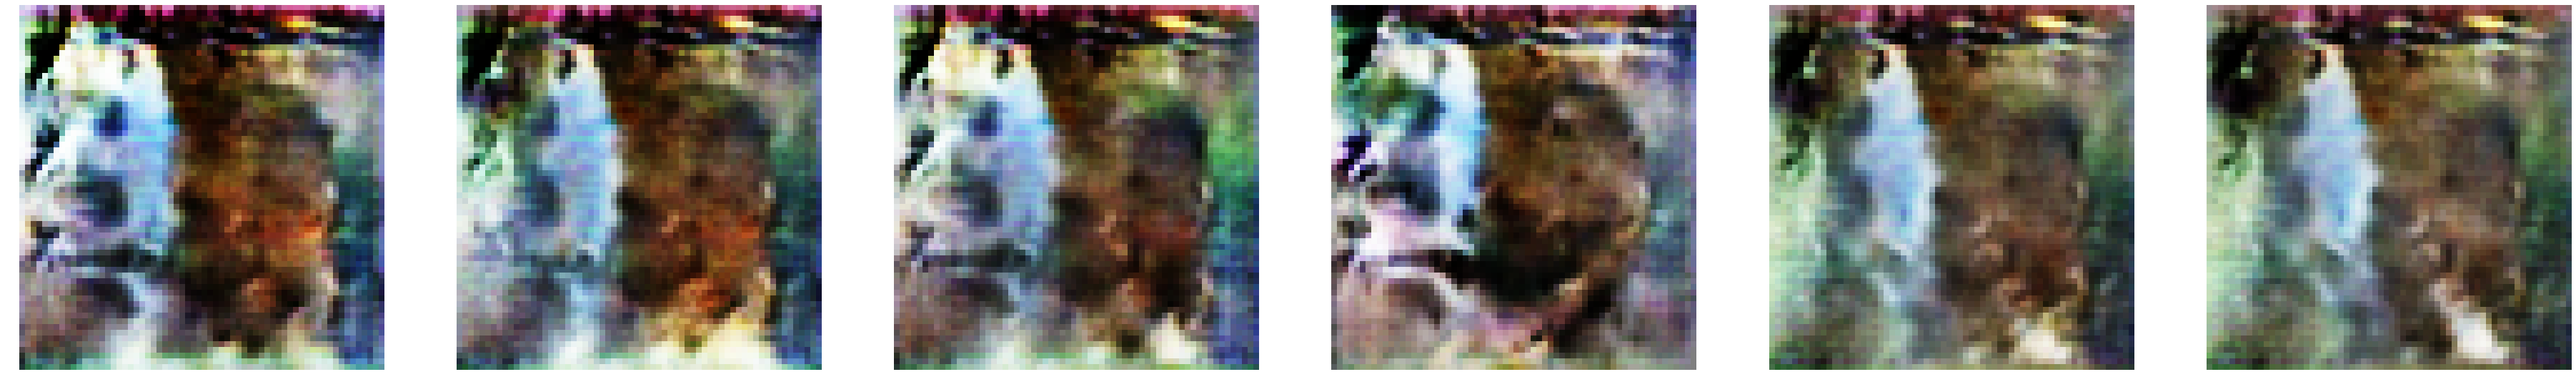

loss=rals 1epochの中での平均値 
 43.03s [192/301] Loss_D: 0.0445 Loss_G: 3.0395 outputR: 0.6812 outputF: -0.1660 / -0.1890
  最後のバッチのloss等 
    43.03s [192/301] Loss_D: 0.0383 Loss_G: 3.0516 outputR: 0.6234 outputF: -0.2870 / -0.2552
loss=rals 1epochの中での平均値 
 42.74s [193/301] Loss_D: 0.0502 Loss_G: 3.0626 outputR: 0.4447 outputF: -0.3909 / -0.4305
  最後のバッチのloss等 
    42.74s [193/301] Loss_D: 0.0222 Loss_G: 3.1628 outputR: 0.2512 outputF: -0.5323 / -0.6174
loss=rals 1epochの中での平均値 
 42.75s [194/301] Loss_D: 0.0463 Loss_G: 3.0485 outputR: 0.6061 outputF: -0.2398 / -0.2648
  最後のバッチのloss等 
    42.75s [194/301] Loss_D: 0.0919 Loss_G: 3.0692 outputR: 0.4906 outputF: -0.5824 / -0.3949
loss=rals 1epochの中での平均値 
 42.79s [195/301] Loss_D: 0.0428 Loss_G: 3.0271 outputR: 0.6558 outputF: -0.1897 / -0.2105
  最後のバッチのloss等 
    42.79s [195/301] Loss_D: 0.0530 Loss_G: 2.9029 outputR: 0.3515 outputF: -0.4170 / -0.4864
loss=rals 1epochの中での平均値 
 43.03s [196/301] Loss_D: 0.0483 Loss_G: 3.0332 outputR: 0.3472 outputF

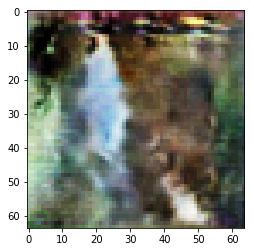

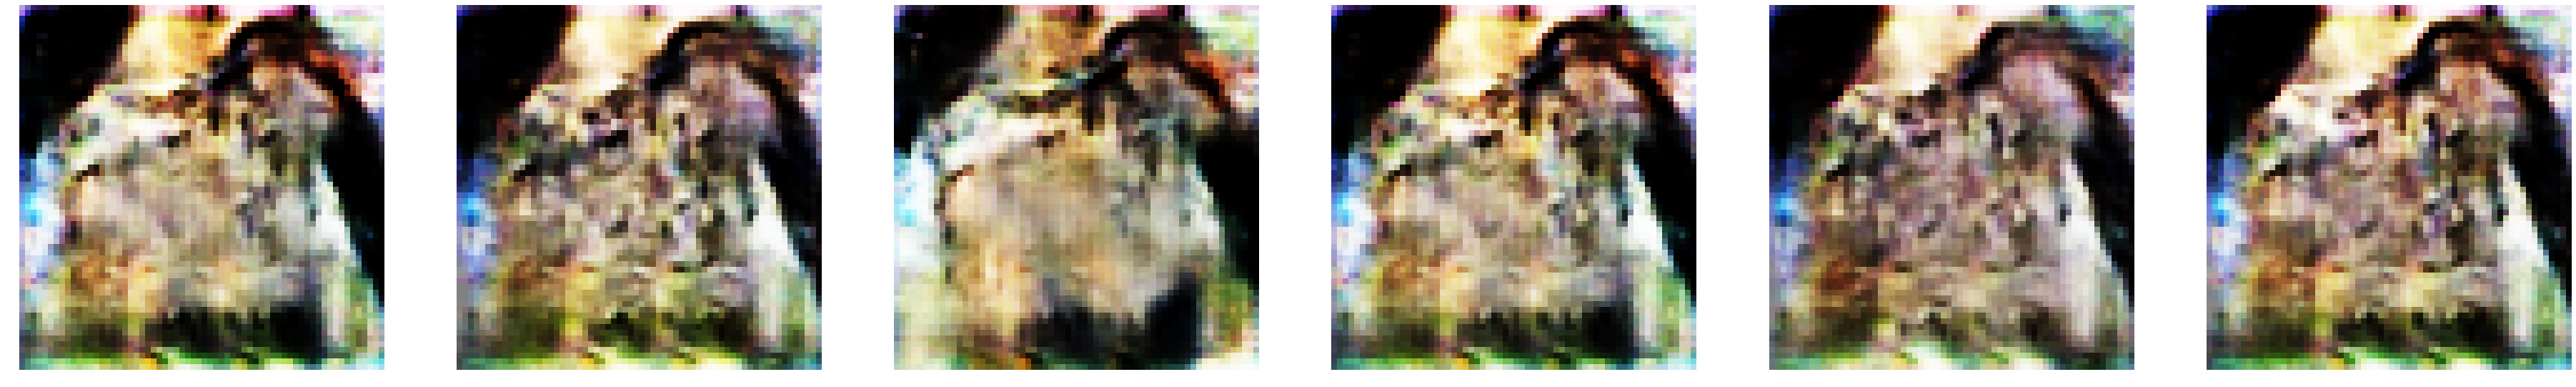

loss=rals 1epochの中での平均値 
 42.96s [202/301] Loss_D: 0.0410 Loss_G: 3.0219 outputR: 0.7582 outputF: -0.0934 / -0.1069
  最後のバッチのloss等 
    42.96s [202/301] Loss_D: 0.0636 Loss_G: 3.3694 outputR: 0.6912 outputF: -0.3176 / -0.2820
loss=rals 1epochの中での平均値 
 43.28s [203/301] Loss_D: 0.0444 Loss_G: 3.0348 outputR: 0.6109 outputF: -0.2333 / -0.2572
  最後のバッチのloss等 
    43.28s [203/301] Loss_D: 0.0421 Loss_G: 2.7661 outputR: 0.6851 outputF: -0.1080 / -0.1216
loss=rals 1epochの中での平均値 
 42.92s [204/301] Loss_D: 0.0414 Loss_G: 3.0363 outputR: 0.6729 outputF: -0.1781 / -0.1956
  最後のバッチのloss等 
    42.92s [204/301] Loss_D: 0.0033 Loss_G: 3.2238 outputR: 0.7072 outputF: -0.1805 / -0.1827
loss=rals 1epochの中での平均値 
 43.03s [205/301] Loss_D: 0.0359 Loss_G: 3.0325 outputR: 0.7784 outputF: -0.0790 / -0.0894
  最後のバッチのloss等 
    43.03s [205/301] Loss_D: 0.0487 Loss_G: 3.1855 outputR: 0.7909 outputF: -0.1589 / -0.1311
loss=rals 1epochの中での平均値 
 43.22s [206/301] Loss_D: 0.0461 Loss_G: 3.0389 outputR: 0.5556 outputF

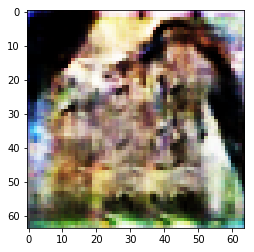

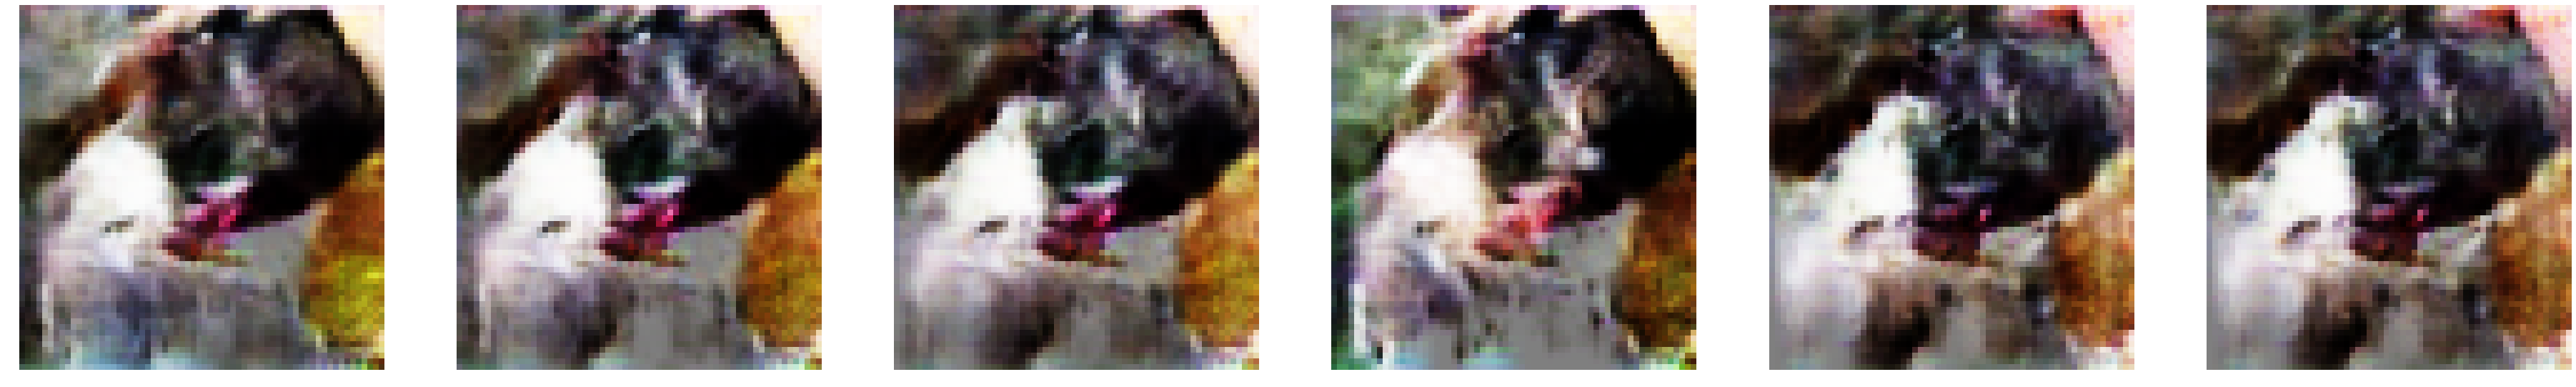

loss=rals 1epochの中での平均値 
 42.73s [212/301] Loss_D: 0.0378 Loss_G: 3.0046 outputR: 0.7738 outputF: -0.0810 / -0.0884
  最後のバッチのloss等 
    42.73s [212/301] Loss_D: 0.0188 Loss_G: 3.1142 outputR: 0.8143 outputF: -0.0722 / -0.0718
loss=rals 1epochの中での平均値 
 43.16s [213/301] Loss_D: 0.0362 Loss_G: 3.0212 outputR: 0.7887 outputF: -0.0677 / -0.0764
  最後のバッチのloss等 
    43.16s [213/301] Loss_D: 0.0186 Loss_G: 2.8485 outputR: 0.6977 outputF: -0.0816 / -0.0811
loss=rals 1epochの中での平均値 
 42.79s [214/301] Loss_D: 0.0425 Loss_G: 3.0358 outputR: 0.6461 outputF: -0.1977 / -0.2224
  最後のバッチのloss等 
    42.79s [214/301] Loss_D: 0.0573 Loss_G: 2.8002 outputR: 0.7639 outputF: -0.0655 / -0.0696
loss=rals 1epochの中での平均値 
 42.76s [215/301] Loss_D: 0.0419 Loss_G: 3.0203 outputR: 0.6731 outputF: -0.1747 / -0.1918
  最後のバッチのloss等 
    42.76s [215/301] Loss_D: 0.0546 Loss_G: 2.7818 outputR: 0.8869 outputF: 0.0489 / 0.0545
loss=rals 1epochの中での平均値 
 42.86s [216/301] Loss_D: 0.0368 Loss_G: 3.0285 outputR: 0.8008 outputF: 

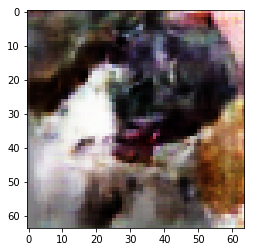

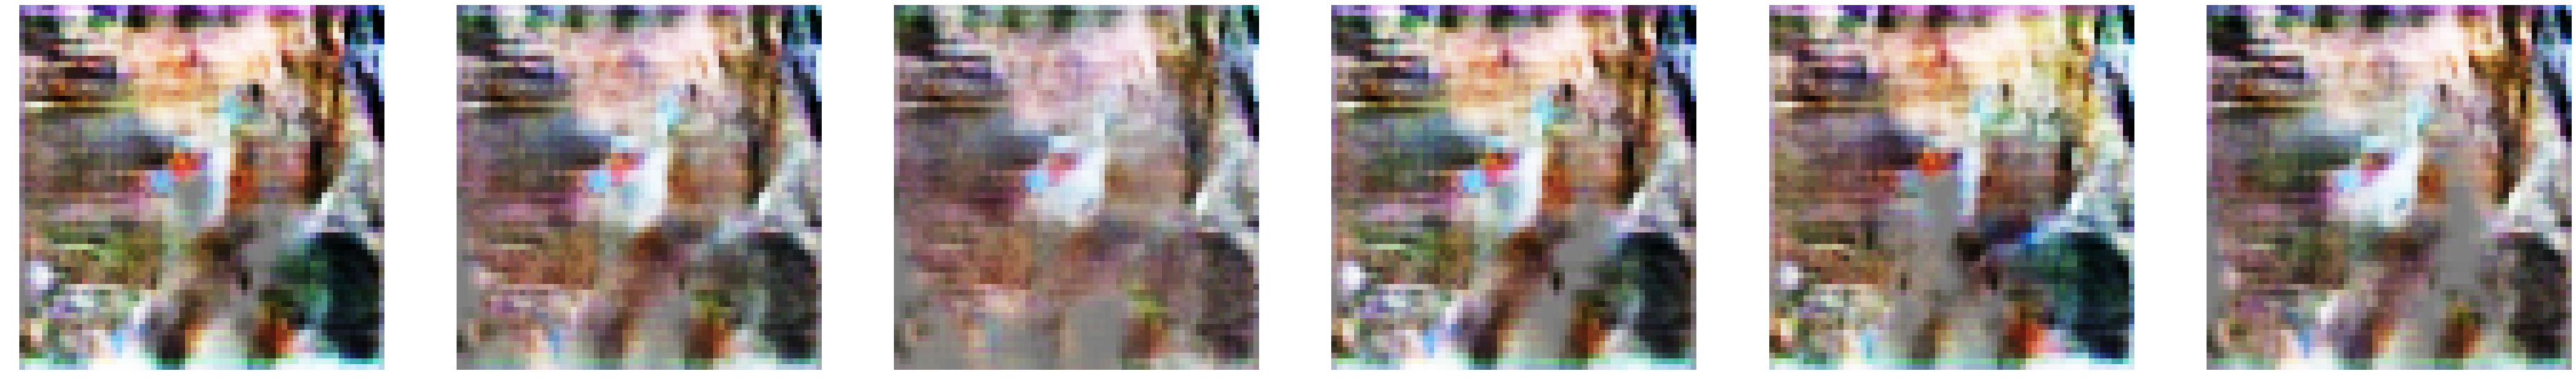

loss=rals 1epochの中での平均値 
 43.08s [222/301] Loss_D: 0.0346 Loss_G: 3.0156 outputR: 0.8708 outputF: 0.0131 / 0.0064
  最後のバッチのloss等 
    43.08s [222/301] Loss_D: 0.0187 Loss_G: 3.0804 outputR: 0.8962 outputF: 0.0252 / 0.0261
loss=rals 1epochの中での平均値 
 42.86s [223/301] Loss_D: 0.0377 Loss_G: 3.0253 outputR: 0.8110 outputF: -0.0424 / -0.0557
  最後のバッチのloss等 
    42.86s [223/301] Loss_D: 0.1088 Loss_G: 2.5165 outputR: 0.6522 outputF: 0.0614 / -0.0663
loss=rals 1epochの中での平均値 
 42.97s [224/301] Loss_D: 0.0359 Loss_G: 3.0285 outputR: 0.8266 outputF: -0.0293 / -0.0411
  最後のバッチのloss等 
    42.97s [224/301] Loss_D: 0.0397 Loss_G: 3.0455 outputR: 0.8109 outputF: -0.0794 / -0.0786
loss=rals 1epochの中での平均値 
 42.85s [225/301] Loss_D: 0.0337 Loss_G: 3.0154 outputR: 0.8451 outputF: -0.0135 / -0.0196
  最後のバッチのloss等 
    42.85s [225/301] Loss_D: 0.0555 Loss_G: 2.8242 outputR: 0.7982 outputF: -0.0472 / -0.0428
loss=rals 1epochの中での平均値 
 42.76s [226/301] Loss_D: 0.0339 Loss_G: 3.0053 outputR: 0.8383 outputF: -0.

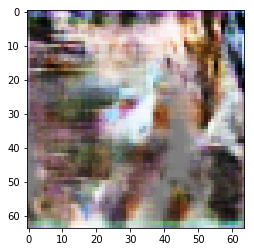

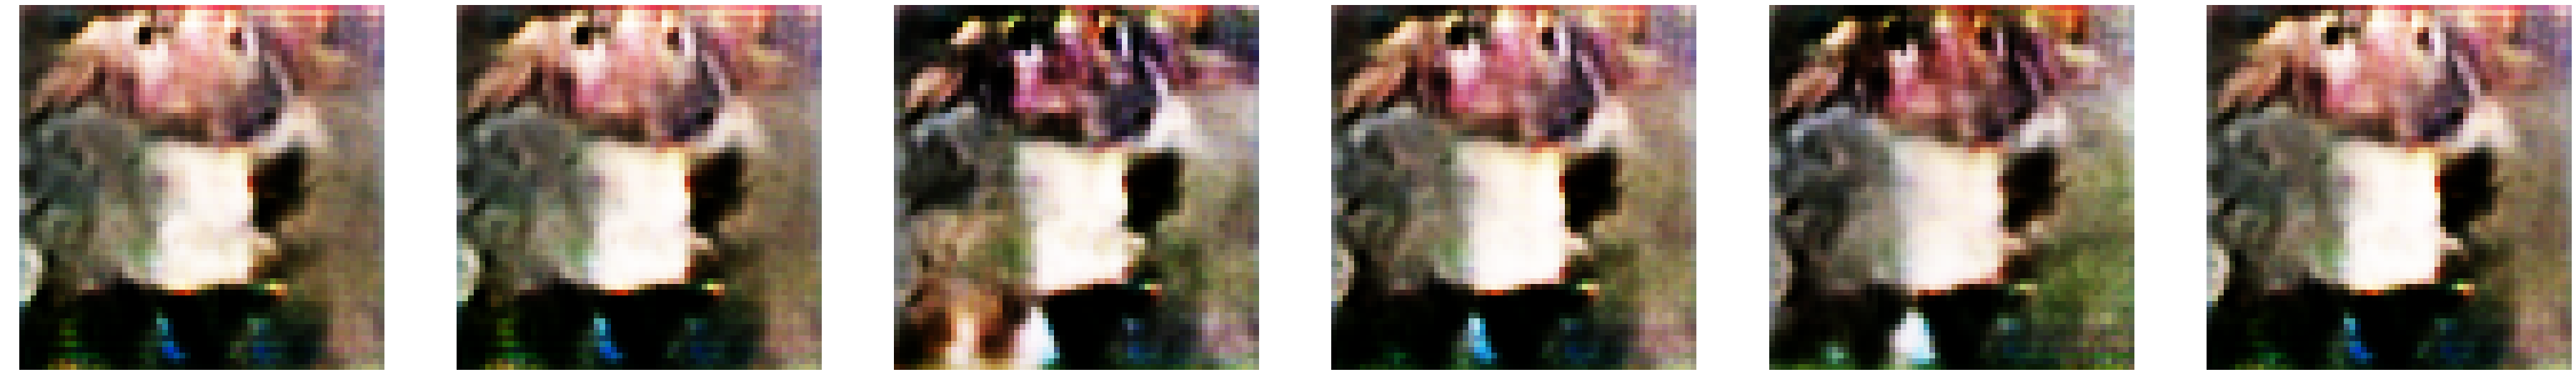

loss=rals 1epochの中での平均値 
 42.95s [232/301] Loss_D: 0.0387 Loss_G: 3.0406 outputR: 0.7166 outputF: -0.1331 / -0.1544
  最後のバッチのloss等 
    42.95s [232/301] Loss_D: 0.0031 Loss_G: 3.0779 outputR: 0.7557 outputF: -0.1021 / -0.0980
loss=rals 1epochの中での平均値 
 42.83s [233/301] Loss_D: 0.0397 Loss_G: 3.0402 outputR: 0.7514 outputF: -0.0975 / -0.1190
  最後のバッチのloss等 
    42.83s [233/301] Loss_D: 0.0581 Loss_G: 3.2913 outputR: 0.6731 outputF: -0.2961 / -0.2890
loss=rals 1epochの中での平均値 
 43.03s [234/301] Loss_D: 0.0351 Loss_G: 3.0220 outputR: 0.8033 outputF: -0.0550 / -0.0626
  最後のバッチのloss等 
    43.03s [234/301] Loss_D: 0.0225 Loss_G: 3.0192 outputR: 0.8553 outputF: -0.0024 / 0.0015
loss=rals 1epochの中での平均値 
 42.76s [235/301] Loss_D: 0.0307 Loss_G: 3.0277 outputR: 0.8427 outputF: -0.0196 / -0.0239
  最後のバッチのloss等 
    42.76s [235/301] Loss_D: 0.0590 Loss_G: 2.8130 outputR: 0.8607 outputF: 0.0213 / 0.0245
loss=rals 1epochの中での平均値 
 42.87s [236/301] Loss_D: 0.0311 Loss_G: 3.0229 outputR: 0.8418 outputF: -

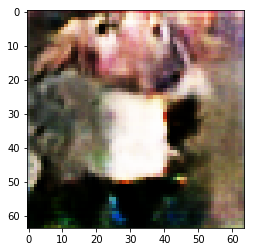

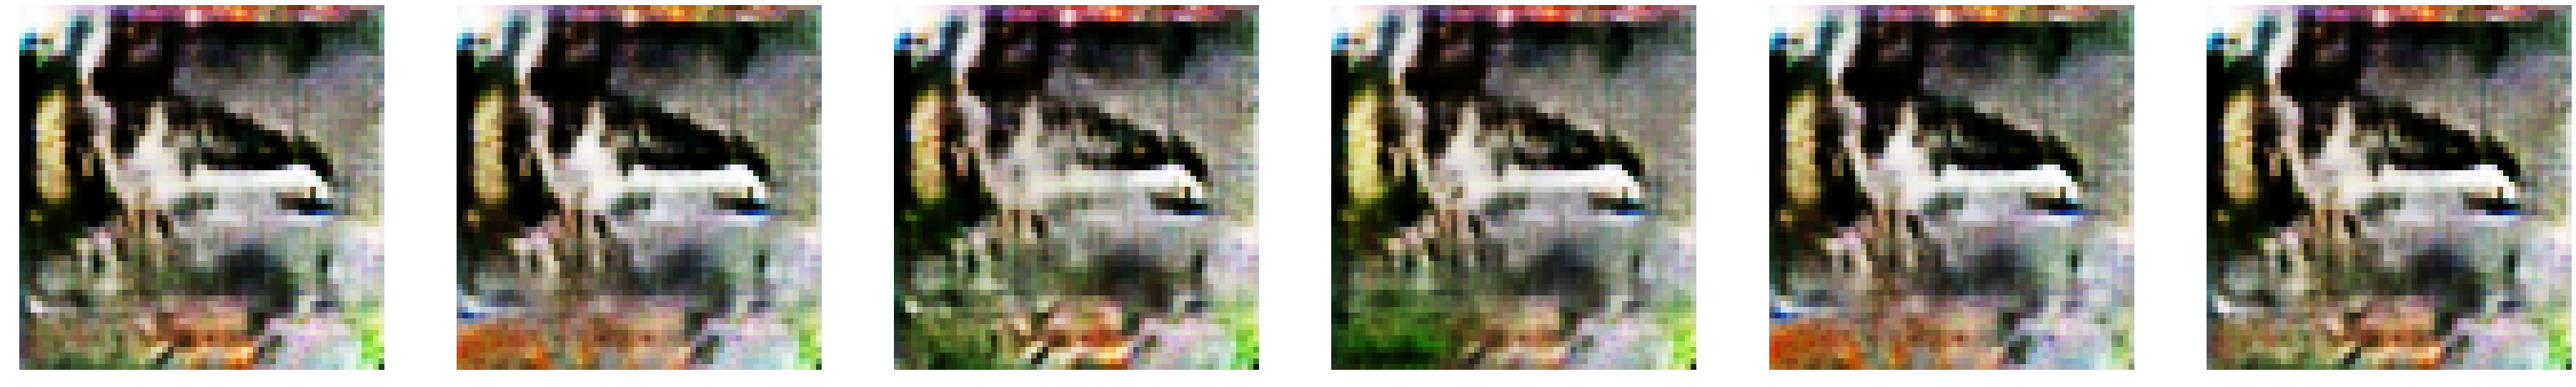

loss=rals 1epochの中での平均値 
 42.98s [242/301] Loss_D: 0.0333 Loss_G: 3.0101 outputR: 0.8862 outputF: 0.0279 / 0.0229
  最後のバッチのloss等 
    42.98s [242/301] Loss_D: 0.0402 Loss_G: 2.9266 outputR: 0.8282 outputF: -0.0236 / -0.0222
loss=rals 1epochの中での平均値 
 42.94s [243/301] Loss_D: 0.0317 Loss_G: 3.0049 outputR: 0.8914 outputF: 0.0315 / 0.0289
  最後のバッチのloss等 
    42.94s [243/301] Loss_D: 0.0230 Loss_G: 3.0131 outputR: 0.8552 outputF: 0.0090 / 0.0079
loss=rals 1epochの中での平均値 
 43.03s [244/301] Loss_D: 0.0344 Loss_G: 3.0369 outputR: 0.8235 outputF: -0.0317 / -0.0462
  最後のバッチのloss等 
    43.03s [244/301] Loss_D: 0.0465 Loss_G: 3.0996 outputR: 0.8889 outputF: -0.0424 / -0.0117
loss=rals 1epochの中での平均値 
 43.11s [245/301] Loss_D: 0.0338 Loss_G: 3.0038 outputR: 0.8258 outputF: -0.0326 / -0.0372
  最後のバッチのloss等 
    43.11s [245/301] Loss_D: 0.0364 Loss_G: 3.0358 outputR: 0.9084 outputF: 0.0245 / 0.0292
loss=rals 1epochの中での平均値 
 43.28s [246/301] Loss_D: 0.0384 Loss_G: 3.0288 outputR: 0.7628 outputF: -0.089

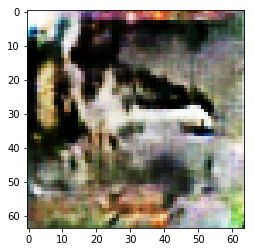

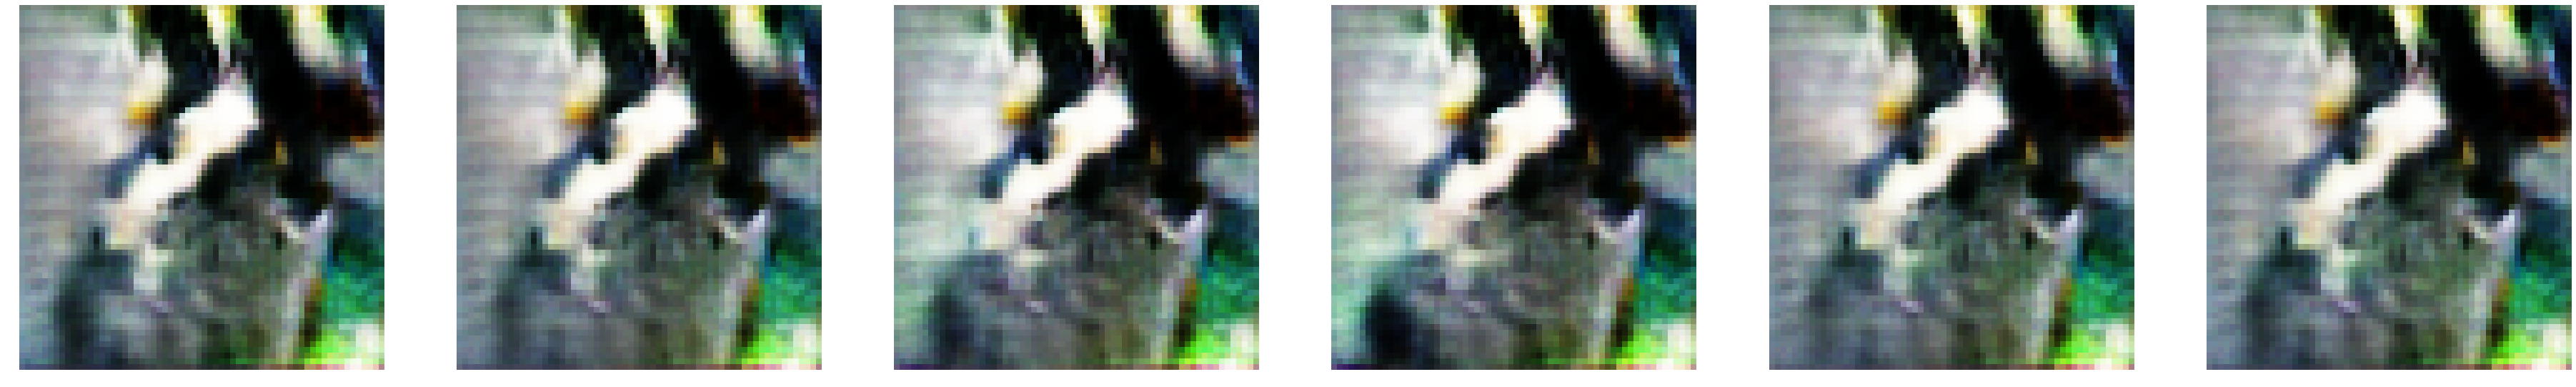

loss=rals 1epochの中での平均値 
 43.00s [252/301] Loss_D: 0.0309 Loss_G: 3.0268 outputR: 0.8636 outputF: 0.0017 / -0.0031
  最後のバッチのloss等 
    43.00s [252/301] Loss_D: 0.0578 Loss_G: 2.7914 outputR: 0.8847 outputF: 0.0519 / 0.0556
loss=rals 1epochの中での平均値 
 42.97s [253/301] Loss_D: 0.0402 Loss_G: 3.0279 outputR: 0.8025 outputF: -0.0466 / -0.0666
  最後のバッチのloss等 
    42.97s [253/301] Loss_D: 0.0575 Loss_G: 2.9568 outputR: 0.8864 outputF: -0.0005 / 0.0063
loss=rals 1epochの中での平均値 
 42.77s [254/301] Loss_D: 0.0405 Loss_G: 3.0567 outputR: 0.7462 outputF: -0.0984 / -0.1281
  最後のバッチのloss等 
    42.77s [254/301] Loss_D: 0.0757 Loss_G: 3.4495 outputR: 0.3167 outputF: -0.7194 / -0.6792
loss=rals 1epochの中での平均値 
 43.04s [255/301] Loss_D: 0.0395 Loss_G: 3.0230 outputR: 0.7978 outputF: -0.0544 / -0.0690
  最後のバッチのloss等 
    43.04s [255/301] Loss_D: 0.0229 Loss_G: 3.0530 outputR: 0.8611 outputF: -0.0139 / -0.0084
loss=rals 1epochの中での平均値 
 42.76s [256/301] Loss_D: 0.0341 Loss_G: 3.0087 outputR: 0.8426 outputF: -0

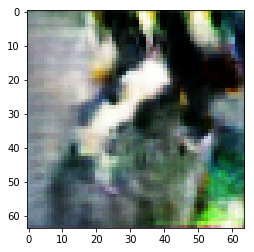

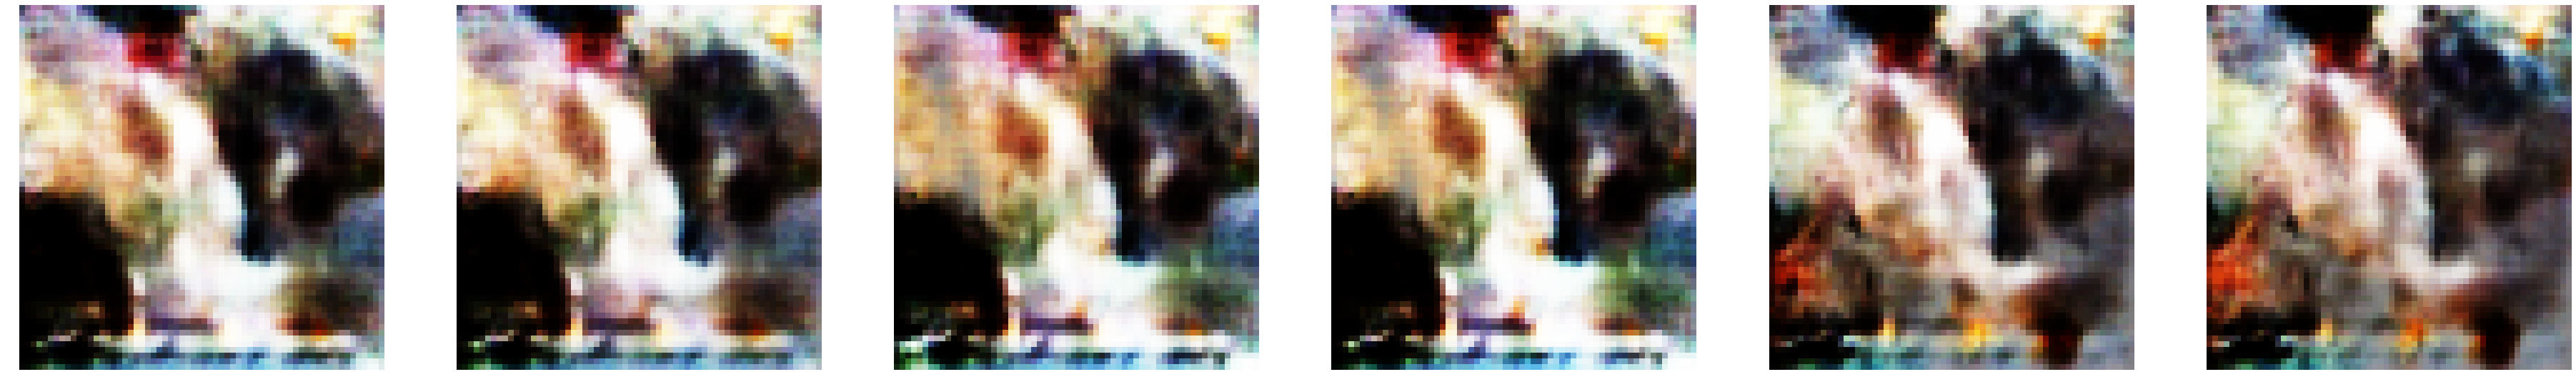

loss=rals 1epochの中での平均値 
 42.99s [262/301] Loss_D: 0.0312 Loss_G: 3.0182 outputR: 0.8433 outputF: -0.0178 / -0.0215
  最後のバッチのloss等 
    42.99s [262/301] Loss_D: 0.0210 Loss_G: 3.0803 outputR: 0.8512 outputF: -0.0199 / -0.0184
loss=rals 1epochの中での平均値 
 42.94s [263/301] Loss_D: 0.0331 Loss_G: 3.0112 outputR: 0.8507 outputF: -0.0083 / -0.0137
  最後のバッチのloss等 
    42.94s [263/301] Loss_D: 0.0017 Loss_G: 3.1745 outputR: 0.8545 outputF: -0.0231 / -0.0283
loss=rals 1epochの中での平均値 
 42.81s [264/301] Loss_D: 0.0343 Loss_G: 3.0263 outputR: 0.8475 outputF: -0.0099 / -0.0200
  最後のバッチのloss等 
    42.81s [264/301] Loss_D: 0.0377 Loss_G: 2.9505 outputR: 0.8693 outputF: 0.0138 / 0.0156
loss=rals 1epochの中での平均値 
 42.88s [265/301] Loss_D: 0.0347 Loss_G: 3.0147 outputR: 0.8360 outputF: -0.0206 / -0.0287
  最後のバッチのloss等 
    42.88s [265/301] Loss_D: 0.0023 Loss_G: 3.0691 outputR: 0.8276 outputF: -0.0321 / -0.0324
loss=rals 1epochの中での平均値 
 42.80s [266/301] Loss_D: 0.0316 Loss_G: 3.0129 outputR: 0.8702 outputF: 

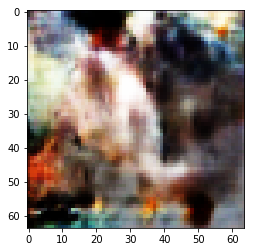

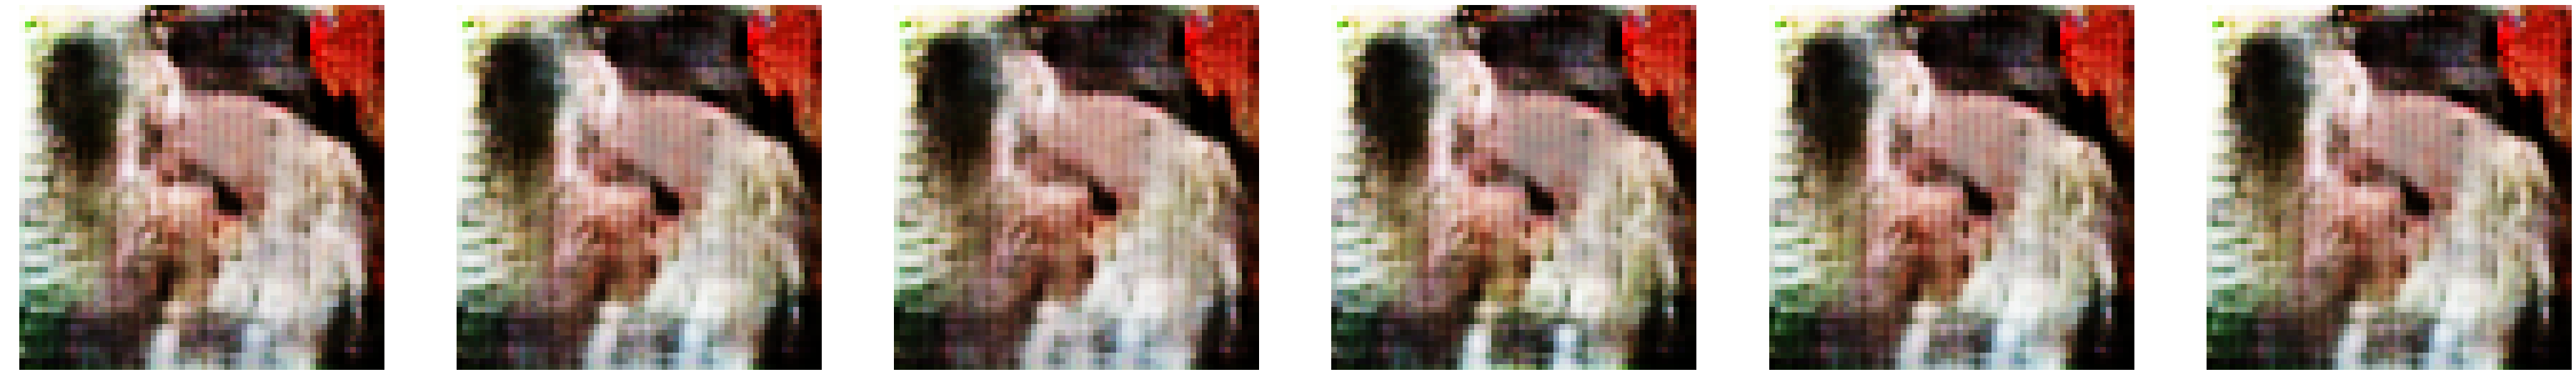

loss=rals 1epochの中での平均値 
 42.86s [272/301] Loss_D: 0.0306 Loss_G: 3.0117 outputR: 0.8835 outputF: 0.0217 / 0.0198
  最後のバッチのloss等 
    42.86s [272/301] Loss_D: 0.0022 Loss_G: 3.1307 outputR: 0.8631 outputF: -0.0027 / -0.0041
loss=rals 1epochの中での平均値 
 42.76s [273/301] Loss_D: 0.0314 Loss_G: 2.9998 outputR: 0.8839 outputF: 0.0231 / 0.0223
  最後のバッチのloss等 
    42.76s [273/301] Loss_D: 0.0540 Loss_G: 2.8663 outputR: 0.8731 outputF: 0.0193 / 0.0205
loss=rals 1epochの中での平均値 
 42.86s [274/301] Loss_D: 0.0342 Loss_G: 3.0188 outputR: 0.8581 outputF: 0.0018 / -0.0080
  最後のバッチのloss等 
    42.86s [274/301] Loss_D: 0.0607 Loss_G: 2.9768 outputR: 0.8072 outputF: -0.0956 / -0.0819
loss=rals 1epochの中での平均値 
 42.96s [275/301] Loss_D: 0.0502 Loss_G: 3.0704 outputR: 0.6136 outputF: -0.2110 / -0.2624
  最後のバッチのloss等 
    42.96s [275/301] Loss_D: 0.0719 Loss_G: 2.4405 outputR: 0.5228 outputF: -0.1959 / -0.1898
loss=rals 1epochの中での平均値 
 43.04s [276/301] Loss_D: 0.0381 Loss_G: 3.0313 outputR: 0.8022 outputF: -0.05

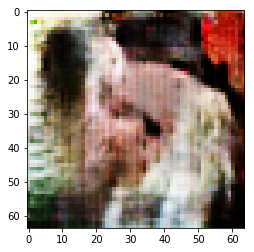

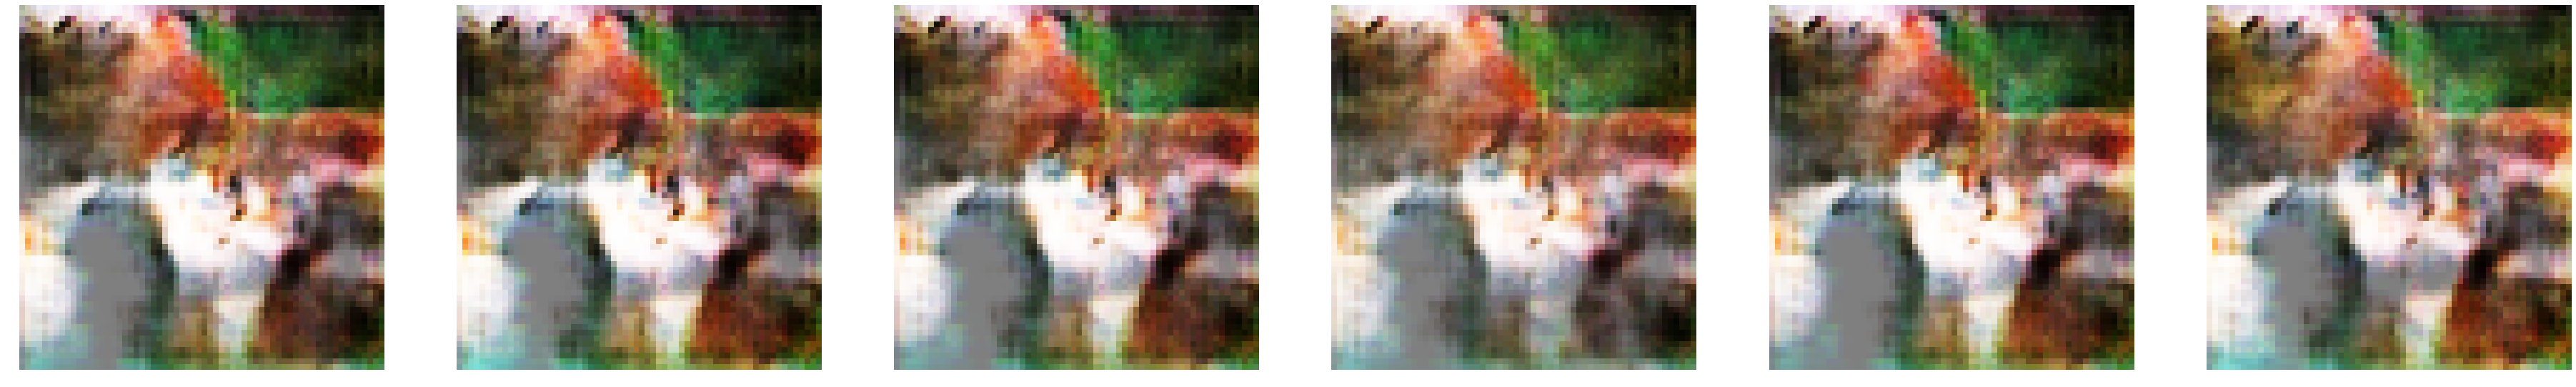

loss=rals 1epochの中での平均値 
 43.13s [282/301] Loss_D: 0.0314 Loss_G: 3.0168 outputR: 0.8947 outputF: 0.0333 / 0.0298
  最後のバッチのloss等 
    43.13s [282/301] Loss_D: 0.0627 Loss_G: 2.9420 outputR: 0.9182 outputF: 0.0361 / 0.0403
loss=rals 1epochの中での平均値 
 43.32s [283/301] Loss_D: 0.0331 Loss_G: 3.0043 outputR: 0.8801 outputF: 0.0218 / 0.0174
  最後のバッチのloss等 
    43.32s [283/301] Loss_D: 0.0241 Loss_G: 3.3560 outputR: 0.9271 outputF: -0.0190 / -0.0147
loss=rals 1epochの中での平均値 
 42.93s [284/301] Loss_D: 0.0404 Loss_G: 3.0594 outputR: 0.8322 outputF: -0.0155 / -0.0432
  最後のバッチのloss等 
    42.93s [284/301] Loss_D: 0.0592 Loss_G: 2.9270 outputR: 0.9256 outputF: 0.0657 / 0.0556
loss=rals 1epochの中での平均値 
 43.05s [285/301] Loss_D: 0.0427 Loss_G: 3.0615 outputR: 0.8125 outputF: -0.0336 / -0.0626
  最後のバッチのloss等 
    43.05s [285/301] Loss_D: 0.0015 Loss_G: 3.2719 outputR: 0.9350 outputF: 0.0319 / 0.0309
loss=rals 1epochの中での平均値 
 42.94s [286/301] Loss_D: 0.0400 Loss_G: 3.0267 outputR: 0.7692 outputF: -0.0779 

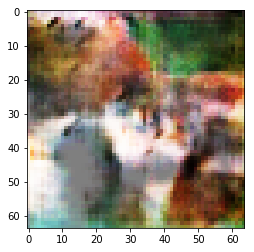

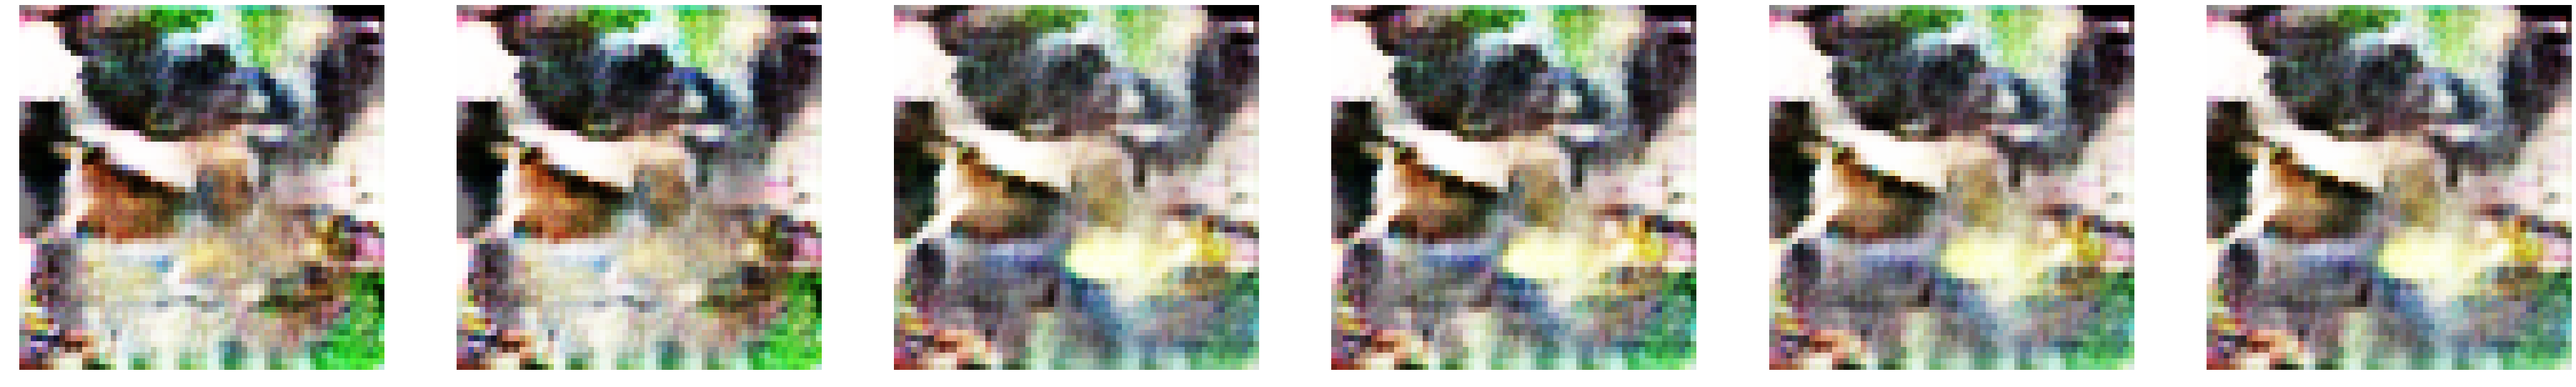

loss=rals 1epochの中での平均値 
 43.03s [292/301] Loss_D: 0.0308 Loss_G: 3.0118 outputR: 0.9249 outputF: 0.0638 / 0.0612
  最後のバッチのloss等 
    43.03s [292/301] Loss_D: 0.0536 Loss_G: 3.0485 outputR: 0.7957 outputF: 0.0760 / -0.0913
loss=rals 1epochの中での平均値 
 42.77s [293/301] Loss_D: 0.0303 Loss_G: 3.0156 outputR: 0.9273 outputF: 0.0650 / 0.0628
  最後のバッチのloss等 
    42.77s [293/301] Loss_D: 0.0398 Loss_G: 2.8929 outputR: 0.8999 outputF: 0.0694 / 0.0660
loss=rals 1epochの中での平均値 
 42.78s [294/301] Loss_D: 0.0314 Loss_G: 3.0082 outputR: 0.9351 outputF: 0.0744 / 0.0719
  最後のバッチのloss等 
    42.78s [294/301] Loss_D: 0.0214 Loss_G: 3.0834 outputR: 0.9284 outputF: 0.0615 / 0.0570
loss=rals 1epochの中での平均値 
 42.92s [295/301] Loss_D: 0.0293 Loss_G: 3.0168 outputR: 0.9255 outputF: 0.0625 / 0.0610
  最後のバッチのloss等 
    42.92s [295/301] Loss_D: 0.0232 Loss_G: 3.1393 outputR: 0.9519 outputF: 0.0738 / 0.0707
loss=rals 1epochの中での平均値 
 42.96s [296/301] Loss_D: 0.0335 Loss_G: 3.0151 outputR: 0.9221 outputF: 0.0637 / 0.05

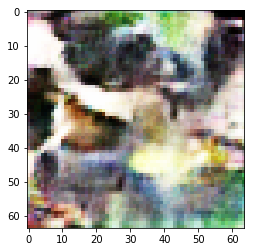

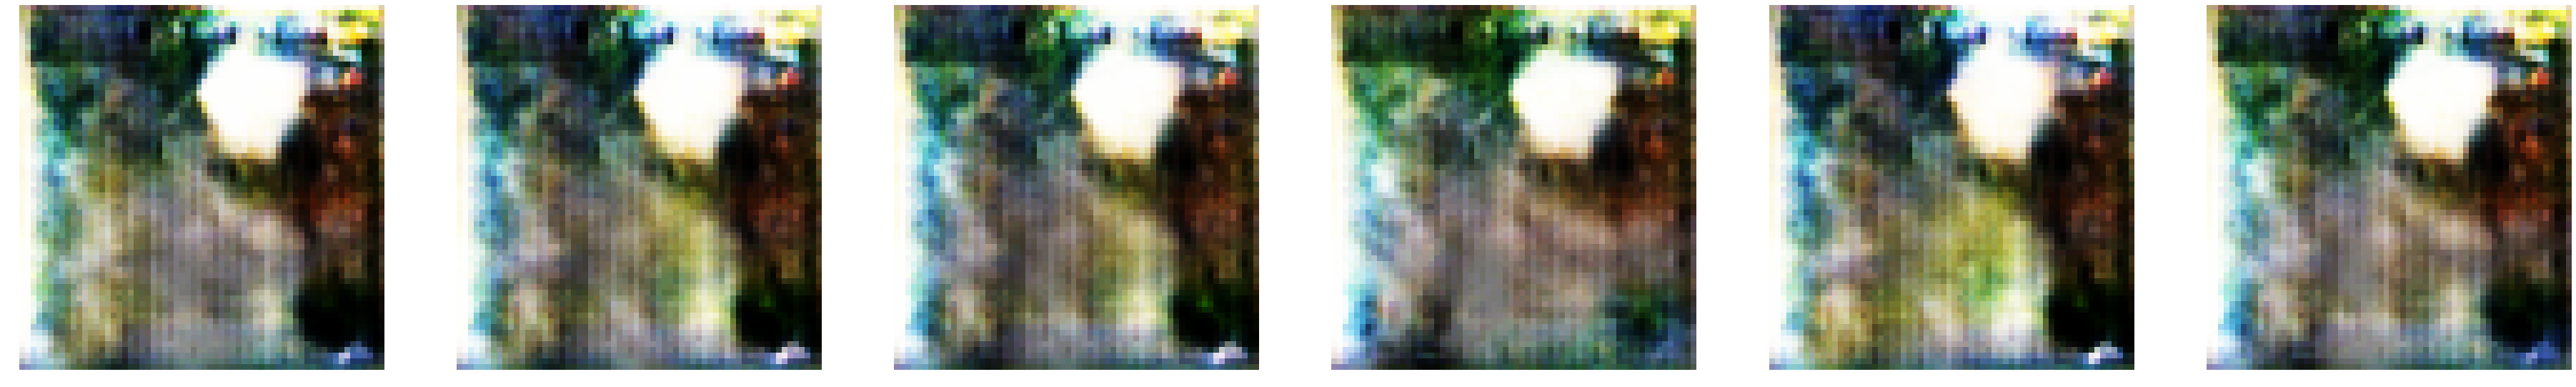

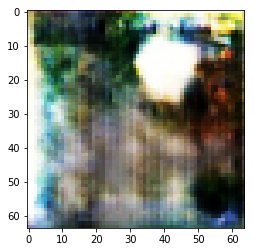

In [14]:
torch.backends.cudnn.benchmark = True

d_loss_log = []
g_loss_log = []
dout_real_log = []
dout_fake_log = []
dout_fake_log2 = []

iter_n = len(train_loader) - 1 #最後の余ったバッチは計算されないから-1

for epoch in range(epochs):
    
    epoch_g_loss = 0.0  # epochの損失和
    epoch_d_loss = 0.0  # epochの損失和
    epoch_dout_real = 0.0
    epoch_dout_fake = 0.0
    epoch_dout_fake2 = 0.0

    epoch_time = time.perf_counter()
    if time.perf_counter() - kernel_start_time > 31000:
            print("Time limit reached! Stopping kernel!"); break

    for ii, (real_images, dog_labels) in enumerate(train_loader):
        if real_images.shape[0]!= BATCH_SIZE: continue
        
        # ラベルにノイズを入れる。そして時々fakeとrealを入れ替える。
        if use_soft_noisy_labels:
            real_labels = torch.squeeze(torch.empty((BATCH_SIZE, 1), device=device).uniform_(*R_uni))
            fake_labels = torch.squeeze(torch.empty((BATCH_SIZE, 1), device=device).uniform_(*F_uni))
            for p in np.random.choice(BATCH_SIZE, size=np.random.randint((BATCH_SIZE//8)), replace=False):
                real_labels[p], fake_labels[p] = fake_labels[p], real_labels[p] # swap labels
        else:
            real_labels = torch.full((BATCH_SIZE, 1), 1.0, device=device)
            fake_labels = torch.full((BATCH_SIZE, 1), 0.0, device=device)
        
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()

        dog_labels = torch.tensor(dog_labels, device=device)
        real_images = real_images.to(device)
        noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=device)
        
        outputR = netD((real_images, dog_labels))
        fake_images = netG((noise, dog_labels))

        outputF = netD((fake_images.detach(), dog_labels))
        if loss_calc == 'rals':
            errD = (torch.mean((outputR - torch.mean(outputF) - real_labels) ** 2) + torch.mean((outputF - torch.mean(outputR) + real_labels) ** 2))/2
        elif loss_calc == 'hinge':
            d_loss_real = torch.nn.ReLU()(1.0 - (outputR - torch.mean(outputF))).mean()
            d_loss_fake = torch.nn.ReLU()(1.0 + (outputF - torch.mean(outputR))).mean()
            errD = (d_loss_real + d_loss_fake) / 2

        errD.backward(retain_graph=True)
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=device)
        fake_images = netG((noise, dog_labels))                                          
        outputF2 = netD((fake_images, dog_labels))
        if loss_calc == 'rals':
            errG = (torch.mean((outputR - torch.mean(outputF2) + real_labels) ** 2) + torch.mean((outputF2 - torch.mean(outputR) - real_labels) ** 2)) / 2
        elif loss_calc == 'hinge':
            errG = (torch.mean(torch.nn.ReLU()(1.0 + (outputR - torch.mean(outputF2)))) + torch.mean(torch.nn.ReLU()(1.0 - (outputF2 - torch.mean(outputR)))))/2
            
        errG.backward()
        optimizerG.step()
        
        lr_schedulerG.step(epoch)
        lr_schedulerD.step(epoch)
        
        # --------------------
        # 3. 記録
        # --------------------
        epoch_d_loss += errD.item()
        epoch_g_loss += errG.item()
        epoch_dout_real += outputR.mean().item()
        epoch_dout_fake += outputF.mean().item()
        epoch_dout_fake2 += outputF2.mean().item()
        
    d_loss_log.append(epoch_d_loss/iter_n)
    g_loss_log.append(epoch_g_loss/iter_n)
    dout_real_log.append(epoch_dout_real/iter_n)
    dout_fake_log.append(epoch_dout_fake/iter_n)
    dout_fake_log2.append(epoch_dout_fake2/iter_n)
        
    if test_mode:
        print('loss=%s 1epochの中での平均値 \n %.2fs [%d/%d] Loss_D: %.4f Loss_G: %.4f outputR: %.4f outputF: %.4f / %.4f' % (loss_calc,
              time.perf_counter()-epoch_time, epoch+1, epochs, d_loss_log[-1], g_loss_log[-1],dout_real_log[-1], dout_fake_log[-1],dout_fake_log2[-1] ))
        print('  最後のバッチのloss等 \n    %.2fs [%d/%d] Loss_D: %.4f Loss_G: %.4f outputR: %.4f outputF: %.4f / %.4f' % (
            time.perf_counter()-epoch_time, epoch+1, epochs, errD.item(), errG.item(),outputR.mean().item(), outputF.mean().item(),outputF2.mean().item() ))
        if epoch > 3:
            if (d_loss_log[-2] < 1e-2) and (d_loss_log[-1] < 1e-2):
                notify(epoch)
                continue
                
    if epoch % 10 == 0:
        files = []
        img = show_generated_img(6)
        plt.imshow(img)
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        files.append({"imageFile": buf})
        message = 'Gattn not Dattnの訓練状況を伝えるよ。\n\n可愛いワンちゃん出来たかな？ \n [%d/%d] \nL_D: %.4f \nL_G: %.4f \noutR: %.4f \noutF: %.4f / %.4f' % (epoch+1, epochs, d_loss_log[-1], g_loss_log[-1],dout_real_log[-1], dout_fake_log[-1],dout_fake_log2[-1] )
        notify(message, files[0])     

## Visualise generated results by label and submit

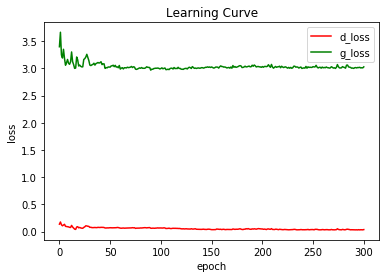

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(d_loss_log,   color="r", label="d_loss")
plt.plot(g_loss_log,   color="g", label="g_loss")

plt.legend(loc="best")

plt.show()

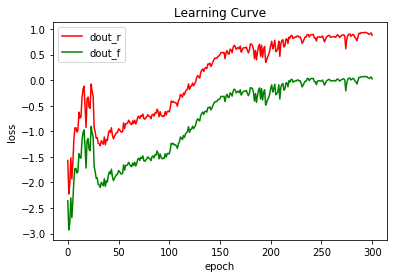

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(dout_real_log, color="r", label="dout_r")
plt.plot(dout_fake_log, color="g", label="dout_f")

plt.legend(loc="best")

plt.show()